# PROJECT: QoT estimation in optical networks

Group H members:


*   Pablo Eduardo Revelo Samaniego
*   Mattia Fiore
*   Pasquale Lobaccaro





In [ ]:
! mkdir pictures

mkdir: cannot create directory ‘pictures’: File exists


In [ ]:
res_folder = "pictures/"

# EUROPEAN DATA

First we do the whole procedure on the first dataset file, representing the european nodes.

## 1. Raw data visualization and analysis

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split ,KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import max_error, mean_squared_error, make_scorer, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve
from lightgbm import LGBMRegressor
import lightgbm as lgb

from helpers import *

In [ ]:
# Leggi il file saltando la prima riga
df = pd.read_csv('Dataset_german_17_node.dat', skiprows=1,delimiter=';', header=None)
# Salva il dataframe in un nuovo file o sovrascrivi l'originale
df.to_csv('Dataset_german_17_node1.dat', index=False, header=False, sep =';')

In [ ]:
# Leggi il file saltando la prima riga
df = pd.read_csv('Dataset_european_19_node.dat', skiprows=1,delimiter=';', header=None)
# Salva il dataframe in un nuovo file o sovrascrivi l'originale
df.to_csv('Dataset_european_19_node1.dat', index=False, header=False, sep =';')
#display(df)

We read the file and get the data from it, saving them in different lists for every type of values.

In [ ]:
#datafile = '/content/Dataset_european_19_node.dat'
datafile = 'Dataset_european_19_node1.dat'

spans, link_occ, snr_values = read_dataset(datafile)

print('Length of span list: ' +str(len(spans)))
print('Length of link occupancy list: ' +str(len(link_occ)))
print('Length of SNR list: ' +str(len(snr_values)))

Length of span list: 1833
Length of link occupancy list: 1833
Length of SNR list: 1833


## 2. Data preprocessing

Then, we need to preprocess the data to get the corresponding path features from it.

First we see a little summary of the raw data, getting the mean, variance and standard deviation of Number of spans, Lightpath length, Number of channels in links and the SNR.

In [ ]:
calculate_m_v_s(spans, link_occ, snr_values)

**********
Number of spans: mean=16.44, var=62.14, std=7.88
Lightpath length: mean=1115.55, var=249003.02, std=499.0
Number of channels in links: mean=34.0, var=528.21, std=22.98
SNR: mean=13.43, var=2.59, std=1.61
**********


In [ ]:
print(spans)
print(link_occ)
print(snr_values)

[[80, 80, 80, 47, 80, 80, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 41], [80, 80, 80, 80, 47, 80, 80, 80, 40], [80, 80, 50, 80, 60, 80, 80, 80, 80, 80, 41, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 41], [80, 80, 80, 80, 80, 41, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 41], [50, 50, 50, 50, 45, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80], [80, 74, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70], [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 50, 50, 50, 50, 45, 80, 80, 80, 80, 80, 76, 80, 80, 80, 80, 65], [70, 70, 70, 49, 80, 74], [80, 60, 80, 80, 80, 80, 80, 76, 80, 80, 80, 80, 30], [80, 80, 50, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 35, 60, 60, 60, 60, 60, 57], [70, 70, 70, 70, 49, 50, 50, 50, 50, 45, 80, 80, 80, 80, 80, 76], [70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 35, 80, 80, 80, 80, 80, 55], [50, 50, 50, 50

Now we fill the X matrix with the corresponding features of the path.
The features for each lightpath will be (columns):

1.   Number of Fiber Spans
2.   Overall Length
3.   The Lenght of the Longest Span
4.   Number of Links
5.   The Total Number of Channels of all the Links
6.   Maximum Number of Channels on a Link







In [ ]:
X = extract_features(spans, link_occ)
print('Shape of features matrix: '+str(X.shape))

Shape of features matrix: (1833, 6)


We now plot the features to try and find a relationship between their values and the SNR obtained.

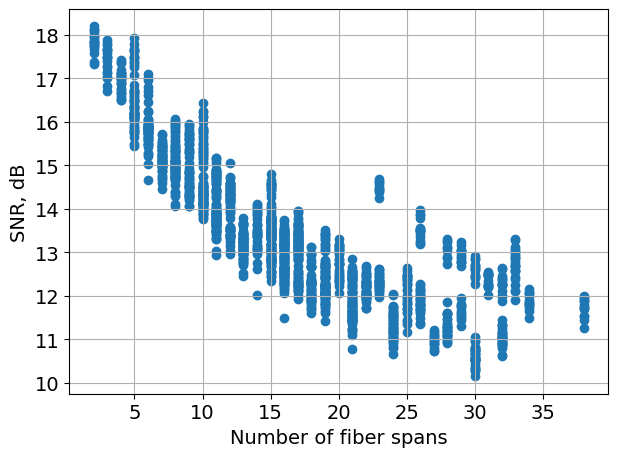

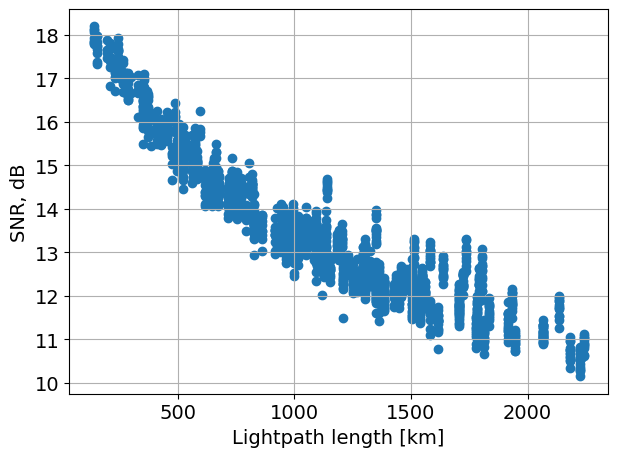

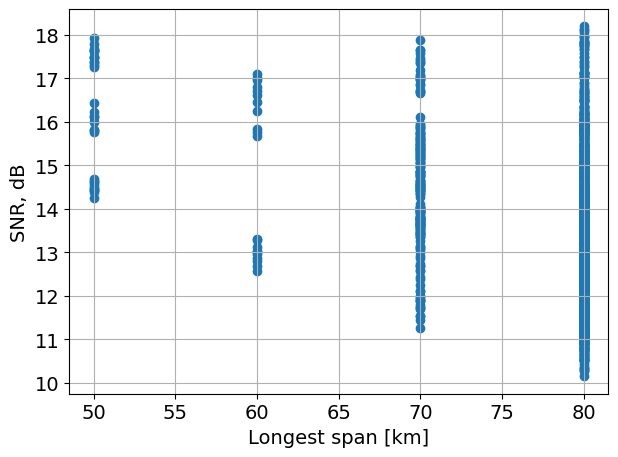

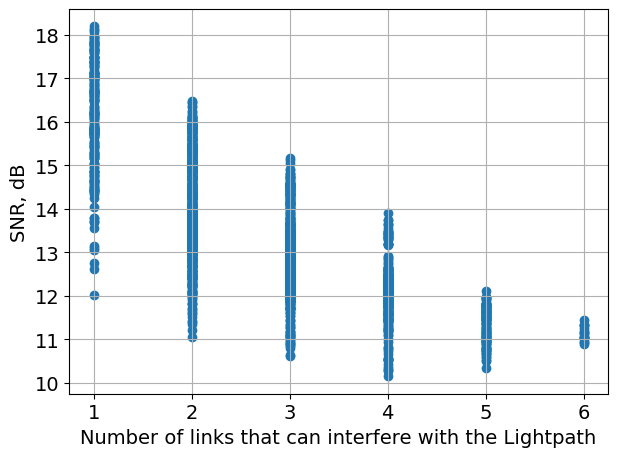

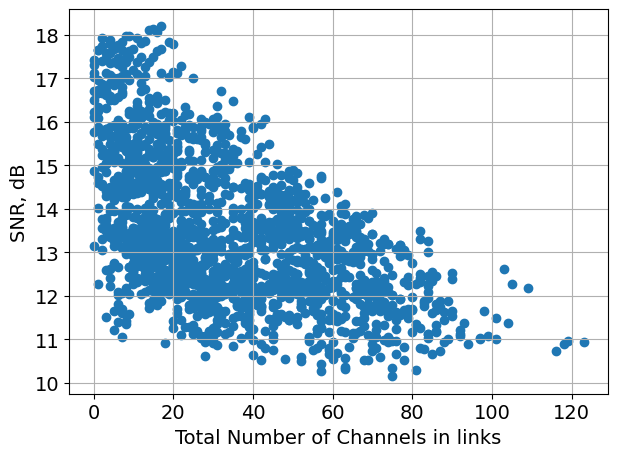

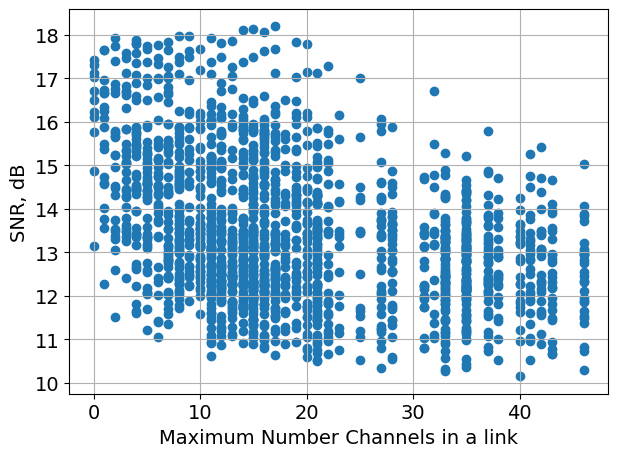

In [ ]:
#F: figure settings to improve readability (customize as you prefer)

FONT_SIZE = 14
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)     # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title

#F: if you want to save figures in a proper directory, uncomment the commented lines below
#res_folder = 'Results'
#if not os.path.exists(res_folder):
#    os.makedirs(res_folder)


x_labels = ['Number of fiber spans', 'Lightpath length [km]', 'Longest span [km]',
            'Number of links that can interfere with the Lightpath',
            'Total Number of Channels in links',
            'Maximum Number Channels in a link',
            ]


for i in range(X.shape[1]):

  plt.scatter(X[:, i], snr_values)
  plt.xlabel(x_labels[i])
  plt.ylabel('SNR, dB')
  plt.grid()
  plt.tight_layout()
  plt.savefig(res_folder+ f'EUROPEAN_FEATURES_{x_labels[i]}.png')
  plt.show()



It can be seen that the "Number of spans",  and the "Lightpath length", are features that are inversely proportional with respect to the SNR of the link. The "Total Number of channels in links" also follow this relation, but not as strong as the previous two features mentioned.

The features of the "Longest span","the number of links that can interfere with the lightpath and the "Maximum Number Channels in a link" don't give a strong or clear relationship with respect to the value of the SNR.


## 3. Part1 LGBM as a Regressor with Probabilistic Regression
Use probabilistic regression and assign MF based on low/high-quantile estimations of SNR.

Using LGBM as regressor, LightGBM can be configured to predict quantiles using the objective parameter set to quantile.


### 3.1 ML optimization and training

In order to properly evaluate the performance of the ML algorithm, we will split the dataset into training and testing. Then, we'll find the best parameters on the training using crossvalidation.

- Training set: 80%
- Testing set: 20%
- Cross-validation 10 fold

In [ ]:
y = np.array(snr_values)#save the SNR values as the y array
print(y)

[12.48 14.72 11.85 ... 11.61 15.04 13.74]


Split the dataset.

In [ ]:
X_train, X_test, y_train, y_test=split_dataset(X,y, True)

(1833, 6)
(1833,)
(1466, 6)
(1466,)
(367, 6)
(367,)


PARAMETERS OF THE ALGORITHM:



*   n_estimators
*   max_depth
*   learning_rate
*   num_leaves
*   min_child_samples
*   subsample
*   colsample_bytree
*   reg_alpha
*   reg_lambda


We define a function to be able to get the best parameters for a different percentage of a quantile, in order to do the probabilistic regresion.


In [ ]:
def optimize_h_lgbm(alp):
  # Define the parameter distributions for random search
  param_dist = {
      'n_estimators': [100, 200, 500],
      'max_depth': [3, 4, 5, -1],  # -1 means no limit
      'learning_rate': [0.01, 0.05, 0.1],
      'num_leaves': [20, 31, 40],
      'min_child_samples': [20, 30, 40],
      'subsample': [0.6, 0.8, 1.0],
      'colsample_bytree': [0.6, 0.8, 1.0],
      'reg_alpha': [0, 0.1, 1],
      'reg_lambda': [0, 0.1, 1],
      'objective': ['quantile'],
      'alpha': [alp],
      'verbosity': [-1]
  }

# Initialize the LGBMRegressor
  model = LGBMRegressor(random_state=42)

# Define the scorer
  scorer = make_scorer(mean_squared_error, greater_is_better=False)

  """
  Randomized Search CV will implement the cross validation for each of the possible
  parameters.
  """

  rand_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring=scorer, cv=5, n_jobs=-1, random_state=42, verbose=False)
  #rand_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring=scorer, cv=10, random_state=42, verbose=False)

# Perform random search
  rand_search.fit(X_train, y_train)

# Print best parameters and best score
  print("Best parameters found: ", rand_search.best_params_)
  print("Best cross-validation score (MSE): ", -rand_search.best_score_)

  # Get the best model
  best_model = rand_search.best_estimator_

# Train the best model on the entire training set
  best_model.fit(X_train, y_train)

# Predict on the training set
  y_pred = best_model.predict(X_train)

# Calculate training MSE
  training_mse = mean_squared_error(y_train, y_pred)
  print("Training MSE: ", training_mse)
  return rand_search.best_params_


Here we get the best parameters of the LGBM regressor for low (10%) and high (90%) quantile.

In [ ]:
best_params_l = optimize_h_lgbm(0.1)
best_params_h = optimize_h_lgbm(0.9)

print('ecco',best_params_l)
print('ecco',best_params_h)

Best parameters found:  {'verbosity': -1, 'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'quantile', 'num_leaves': 20, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'alpha': 0.1}
Best cross-validation score (MSE):  0.13045557316431197
Training MSE:  0.11055345512917264
Best parameters found:  {'verbosity': -1, 'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'quantile', 'num_leaves': 20, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'alpha': 0.9}
Best cross-validation score (MSE):  0.11795508753482031
Training MSE:  0.09872066708230953
ecco {'verbosity': -1, 'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'quantile', 'num_leaves': 20, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'alpha': 0.1}
ecco {'verbosity': -1, 'subsample': 1.0, 'reg_lambda': 0,

We also defined a function "SNR_to_MF(SNR)" on the helpers.py script, to convert the values of the SNR to the corresponding Modulation Format (MF), according to the table given on the project slides.



### 3.2 Without Hyperparameters optimization

First do the procedure straighforward, without the cross validation.

In [ ]:
# Convert SNR values to modulation formats for ground truth labels
#y_modulation = np.array([SNR_to_MF(snr) for snr in y])

# Split the data into training and testing sets
y_modulation_train = [SNR_to_MF(i) for i in y_train]
y_modulation_test = [SNR_to_MF(i) for i in y_test]

# Define the LightGBM regressor for quantile regression
params = {
    'objective': 'quantile',
    'alpha': 0.1,  # For 10th percentile
    'verbosity':[-1]
}
start_time = time.time()
snr_regressor_low = lgb.LGBMRegressor(**params)
snr_regressor_low.fit(X_train, y_train)

params['alpha'] = 0.9  # For 90th percentile
snr_regressor_high = lgb.LGBMRegressor(**params)
snr_regressor_high.fit(X_train, y_train)
training_duration = time.time() - start_time
print(f"Training duration {training_duration}")

# Predict SNR values on the test set
start = time.time()
y_snr_pred_low = snr_regressor_low.predict(X_test)
end = time.time()
y_snr_pred_high = snr_regressor_high.predict(X_test)
end2 = time.time()

print(f"{end-start}")
print(f"{end2-start}")

print("DONE")

Training duration 0.09634208679199219
0.006251096725463867
0.010294437408447266
DONE


Define a function to get the predicted SNR and MFs, and then calculate the metrics for it.

In [ ]:
def calculate_metrics(y_snr_pred_low,
                      y_snr_pred_high,
                      y_test,
                      y_modulation_test,
                      verbose = False):

  # Convert the predicted quantiles to modulation formats
  y_snr_pred_mean = (y_snr_pred_low + y_snr_pred_high) / 2
  y_modulation_pred = np.array([SNR_to_MF(snr) for snr in y_snr_pred_mean])

  if verbose:
    # Regression Metrics
    mse = mean_squared_error(y_test, y_snr_pred_mean)
    mae = mean_absolute_error(y_test, y_snr_pred_mean)

    # Classification Metrics
    accuracy = accuracy_score(y_modulation_test, y_modulation_pred)
    precision = precision_score(y_modulation_test, y_modulation_pred, average='weighted')
    recall = recall_score(y_modulation_test, y_modulation_pred, average='weighted')
    f1 = f1_score(y_modulation_test, y_modulation_pred, average='weighted')

    # Output results
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')

  return y_modulation_pred

In [ ]:
y_modulation_pred = calculate_metrics(y_snr_pred_low,
                                      y_snr_pred_high,
                                      y_test,
                                      y_modulation_test,
                                      True)

Mean Squared Error: 0.06
Mean Absolute Error: 0.19
Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1-score: 0.93


Define another function to get the number of incorrectly-assigned MFs.

In [ ]:
def pred_values_lgbm_reg(y_modulation_pred,y_modulation_test):
  #print('***** NON MARGINED PREDICTED SNR *****')
  num_diff_MF = 0
  num_overrated_MF = 0
  num_underrated_MF = 0

  for i in range(len(y_test)):
      if (y_modulation_pred[i]) != (y_modulation_test[i]):
        #print('I found a different MF: {} vs {} (pred vs ground truth)'.format(SNR_to_MF(y_predicted[i]), SNR_to_MF(y_test[i])))
          num_diff_MF += 1
          if (y_modulation_pred[i]) > (y_modulation_test[i]):
              num_overrated_MF +=1
          else:
              num_underrated_MF +=1

  print('Number of incorrectly-assigned MFs: ' + str(num_diff_MF))
  print('Number of overrated MFs: ' + str(num_overrated_MF))
  print('Number of underrated MFs: ' + str(num_underrated_MF))

  return [num_diff_MF,num_overrated_MF,num_underrated_MF]



In [ ]:
p1=pred_values_lgbm_reg(y_modulation_pred,y_modulation_test)

Number of incorrectly-assigned MFs: 26
Number of overrated MFs: 12
Number of underrated MFs: 14


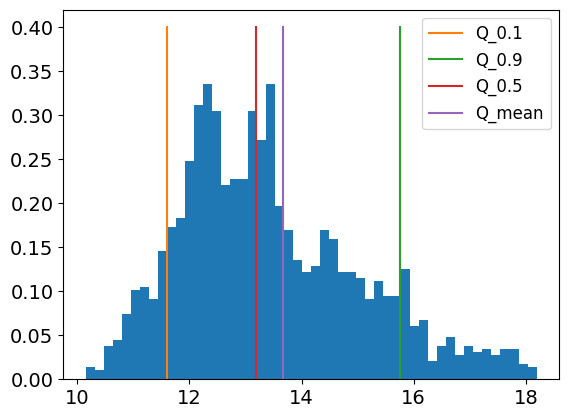

In [ ]:
from math import ceil

plt.hist(y, bins=50, density=True)
q10 = np.quantile(y, 0.1)
q90 = np.quantile(y, 0.9)
q50 = np.quantile(y, 0.5)
qmean = (q10 + q90)/2

plt.plot([q10, q10], [0,0.4])
plt.plot([q90, q90], [0,0.4])
plt.plot([q50, q50], [0,0.4])
plt.plot([qmean, qmean], [0,0.4])

plt.legend(["Q_0.1", "Q_0.9", "Q_0.5", "Q_mean"])

### 3.3 Using the Best Parameters found

Now do the technique, but with the best parameters found for low and high quartiles.

In [ ]:
#Define the best parameters for both cases
params1 = best_params_l
params2 = best_params_h



def lgbm_regr(X_train, X_test, y_train, y_test):
  # Define the LightGBM regressor for quantile regression
  start_time = time.time()
  snr_regressor_low = lgb.LGBMRegressor(**params1)
  snr_regressor_low.fit(X_train, y_train)

  #params['alpha'] = 0.9  # For 90th percentile
  snr_regressor_high = lgb.LGBMRegressor(**params2)
  snr_regressor_high.fit(X_train, y_train)
  training_duration = time.time() - start_time

# Predict SNR values on the test set
  y_snr_pred_low = snr_regressor_low.predict(X_test)
  y_snr_pred_high = snr_regressor_high.predict(X_test)

  print("DONE")

  return y_snr_pred_low,y_snr_pred_high,training_duration

In [ ]:
y_snr_pred_low,y_snr_pred_high,training_duration = lgbm_regr(X_train, X_test, y_train, y_test)

DONE


In [ ]:
y_modulation_pred = calculate_metrics(y_snr_pred_low,y_snr_pred_high, y_test, y_modulation_test,True)

Mean Squared Error: 0.06
Mean Absolute Error: 0.18
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-score: 0.94


In [ ]:
p1_cross=pred_values_lgbm_reg(y_modulation_pred,y_modulation_test)

Number of incorrectly-assigned MFs: 22
Number of overrated MFs: 12
Number of underrated MFs: 10


In [ ]:
print(p1)
print(p1_cross)

[26, 12, 14]
[22, 12, 10]


### Choosing how much to push


In [ ]:
quantiles = [0.1, 0.5 ,0.9]
values = []
for i in range(len(quantiles)):
  params = {'verbosity': -1,
                       'subsample': 1.0,
                       'reg_lambda': 0,
                       'reg_alpha': 0,
                       'objective': 'quantile',
                       'num_leaves': 20,
                       'n_estimators': 200,
                       'min_child_samples': 20,
                       'max_depth': -1,
                       'learning_rate': 0.1,
                       'colsample_bytree': 0.8,
                       'alpha': quantiles[i]}

  start_time = time.time()
  snr_regressor = lgb.LGBMRegressor(**params)
  snr_regressor.fit(X_train, y_train)
  end = time.time()

  y_snr_pred = snr_regressor.predict(X_test)
  values.append(y_snr_pred)



Text(0.5, 1.0, 'Quantile Regression')

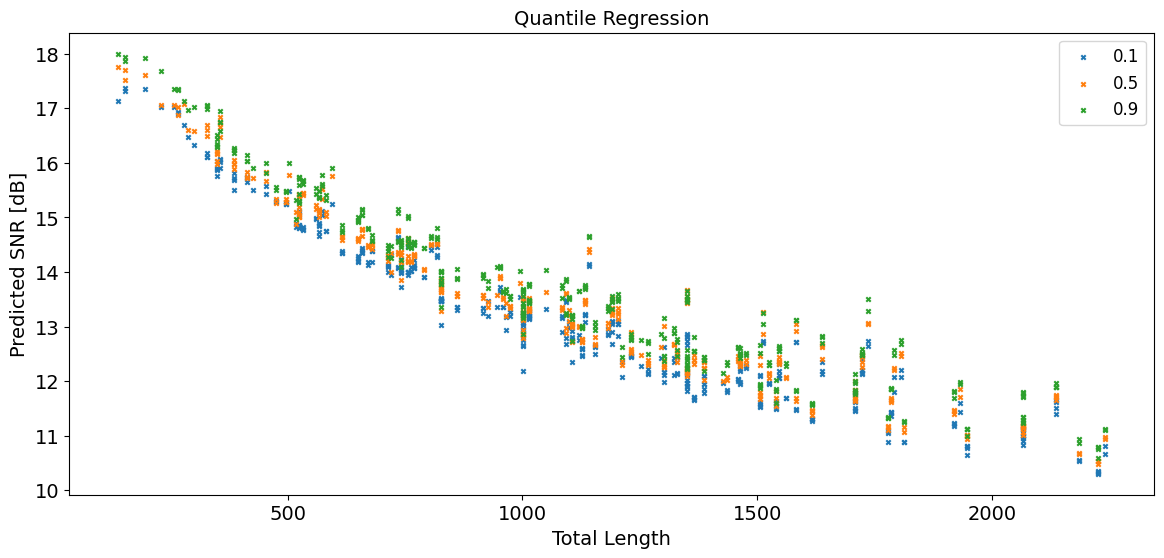

In [ ]:
plt.figure(figsize = (14,6))
for i in range(len(values)):

  plt.scatter(X_test[:,1], values[i], s = 10, marker ='x')

plt.legend([str(round(i,2)) for i in quantiles])
plt.ylabel("Predicted SNR [dB]")
plt.xlabel("Total Length")
plt.title("Quantile Regression")



In [ ]:
MF_test = [SNR_to_MF(i) for i in y_test]

pablo = (y_snr_pred_low + y_snr_pred_high)/2
values.append(pablo)

In [ ]:
massimo = 0
for i in range(len(values)):

  over, under, correct = 0, 0, 0
  roba = [SNR_to_MF(j) for j in values[i]]

  for k in range(len(roba)):
    if roba[k] == MF_test[k]:
      correct += 1
    elif roba[k] > MF_test[k]:
      over += 1
    else:
      under += 1

    if correct > massimo:
      massimo = correct


  print("#########################")
  print(f"CORRECT: {correct}\nUNDER: {under}\nOVER: {over}")


print(f"MAX: {massimo}")

#########################
CORRECT: 327
UNDER: 37
OVER: 3
#########################
CORRECT: 340
UNDER: 21
OVER: 6
#########################
CORRECT: 342
UNDER: 14
OVER: 11
#########################
CORRECT: 341
UNDER: 7
OVER: 19
#########################
CORRECT: 336
UNDER: 2
OVER: 29
#########################
CORRECT: 345
UNDER: 10
OVER: 12
MAX: 345


It can be seen that with the hyperparameters obtained we got 4 less incorrectly-assigned MFs, so this helps a lot to do this procedure to get a higher accuracy with our ML procedure. Below you can see this comparision in a graph.

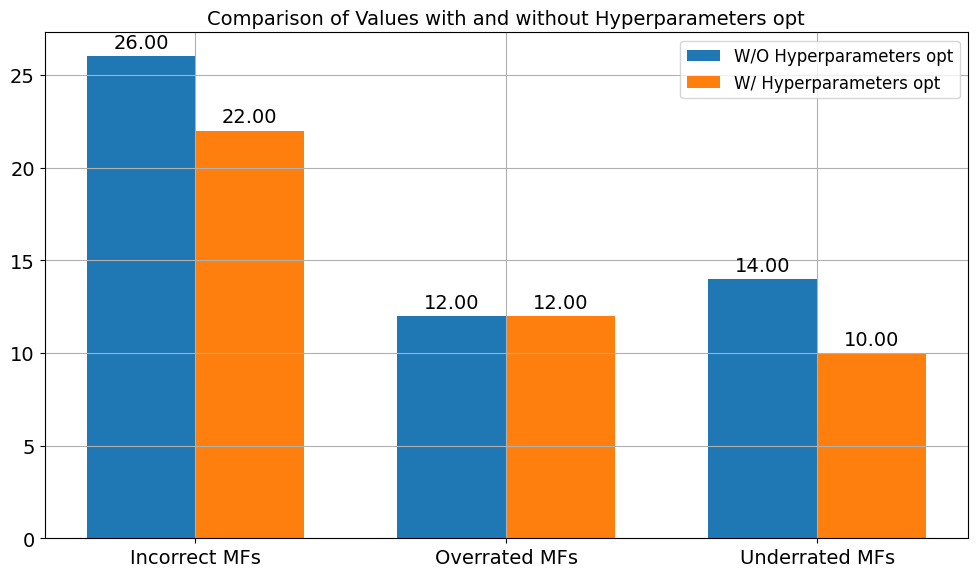

In [ ]:
# Define labels for each pair of values
labels = ['Incorrect MFs', 'Overrated MFs', 'Underrated MFs']

# Create an array with positions of the bars
x = np.arange(len(labels))  # the label locations

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
bars1 = ax.bar(x - width/2, p1, width, label='W/O Hyperparameters opt')
bars2 = ax.bar(x + width/2, p1_cross, width, label='W/ Hyperparameters opt')


ax.set_title('Comparison of Values with and without Hyperparameters opt')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)


fig.tight_layout()
plt.grid()
# Show the plot
plt.savefig(res_folder+f'COMPARISON_EUROPEAN_1.png')
plt.show()


### 3.4 Simpler models

We also analyze few simpler models (Linear Regression and K-Nearest Neighbor) in order to establish the performance of the approach used.

#### 3.4.1 Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

# Define the Linear Regression model
lr_snr_regressor = LinearRegression()

# Train the model on the training data
start_time = time.time()
lr_snr_regressor.fit(X_train, y_train)
lr_training_duration = time.time() - start_time

# Predict SNR values on the test set
lr_y_snr_pred = lr_snr_regressor.predict(X_test)

# Calculate the metrics
y_lr_modulation_pred = calculate_metrics(lr_y_snr_pred, lr_y_snr_pred, y_test, y_modulation_test,True)  # Use the same for both low and high since LinearRegression doesn't provide quantiles


Mean Squared Error: 0.16
Mean Absolute Error: 0.30
Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1-score: 0.93


In [ ]:
p1_lr_cross=pred_values_lgbm_reg(y_lr_modulation_pred,y_modulation_test)

Number of incorrectly-assigned MFs: 27
Number of overrated MFs: 18
Number of underrated MFs: 9


This model gives a slightly less accurate results, compared to the LGBM one.

#### 3.4.2 *K-Nearest Neighbors*

Now, we try using the K-Nearest Neighbors for the regression tasks.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Define the K-Nearest Neighbors model
kn_snr_regressor = KNeighborsRegressor()

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
}

# Instantiate the grid search
grid_search = GridSearchCV(estimator=kn_snr_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search
start_time = time.time()
grid_search.fit(X_train, y_train)
grid_search_duration = time.time() - start_time

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (Negative MSE):", grid_search.best_score_)

Best Parameters: {'n_neighbors': 5}
Best CV Score (Negative MSE): -0.059354015137795736


The best number of neighbors for knn in this case is 5

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Define the K-Nearest Neighbors model
kn_snr_regressor = KNeighborsRegressor(n_neighbors=5)

# Train the model on the training data
start_time = time.time()
kn_snr_regressor.fit(X_train, y_train)
kn_training_duration = time.time() - start_time

# Predict SNR values on the test set
y_kn_snr_pred = kn_snr_regressor.predict(X_test)

# Calculate the metrics
y_kn_modulation_pred = calculate_metrics(y_kn_snr_pred, y_kn_snr_pred, y_test, y_modulation_test,True)  # Use the same for both low and high since KNeighborsRegressor doesn't provide quantiles


Mean Squared Error: 0.06
Mean Absolute Error: 0.19
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1-score: 0.92


In [ ]:
p1_kn_cross=pred_values_lgbm_reg(y_kn_modulation_pred,y_modulation_test)

Number of incorrectly-assigned MFs: 28
Number of overrated MFs: 13
Number of underrated MFs: 15


The KNN gave a worse result than the Linear Regression, as well.

#### 3.4.3 K-NN + Normalization

Normalization can improve the performance and accuracy of the KNN model. When features are on similar scales, distance calculations better reflect the true differences between data points. This can lead to more accurate predictions, as the most relevant neighbors are considered. So here we considered also the normalized case

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Normalize X
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

display (X_train_scaled)
#display (y_train_scaled)
display (X_test_scaled)
#display (y_test_scaled)
# Define the K-Nearest Neighbors model
kn_snr_regressor = KNeighborsRegressor(n_neighbors=5)

# Train the model on the training data
start_time = time.time()
kn_snr_regressor.fit(X_train_scaled, y_train)
kn_training_duration = time.time() - start_time

# Predict SNR values on the test set
y_kn_snr_pred = kn_snr_regressor.predict(X_test_scaled)

# Calculate the metrics
y_kn_modulation_pred = calculate_metrics(y_kn_snr_pred, y_kn_snr_pred, y_test, y_modulation_test,True)


array([[0.36111111, 0.43333333, 0.66666667, 0.        , 0.08130081,
        0.2173913 ],
       [0.19444444, 0.17333333, 0.66666667, 0.2       , 0.17073171,
        0.36956522],
       [0.38888889, 0.43333333, 1.        , 0.4       , 0.37398374,
        0.60869565],
       ...,
       [0.38888889, 0.46      , 1.        , 0.4       , 0.58536585,
        0.91304348],
       [0.22222222, 0.28333333, 1.        , 0.2       , 0.13821138,
        0.2826087 ],
       [0.66666667, 0.74666667, 1.        , 0.6       , 0.34146341,
        0.34782609]])

array([[0.44444444, 0.57666667, 1.        , 0.4       , 0.32520325,
        0.60869565],
       [0.25      , 0.34333333, 1.        , 0.2       , 0.43902439,
        0.76086957],
       [0.27777778, 0.3       , 1.        , 0.2       , 0.16260163,
        0.2173913 ],
       ...,
       [0.22222222, 0.28666667, 1.        , 0.2       , 0.37398374,
        0.76086957],
       [0.66666667, 0.74666667, 1.        , 0.8       , 0.60162602,
        0.54347826],
       [0.08333333, 0.11666667, 1.        , 0.        , 0.11382114,
        0.30434783]])

Mean Squared Error: 0.07
Mean Absolute Error: 0.20
Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1-score: 0.93


In [ ]:
p1_kn_norm=pred_values_lgbm_reg(y_kn_modulation_pred,y_modulation_test)

Number of incorrectly-assigned MFs: 27
Number of overrated MFs: 15
Number of underrated MFs: 12


Even normalized, the KNN doesn't improve the LGBM model results.

### 3.5 Comparison Simpler Models vs LGBM

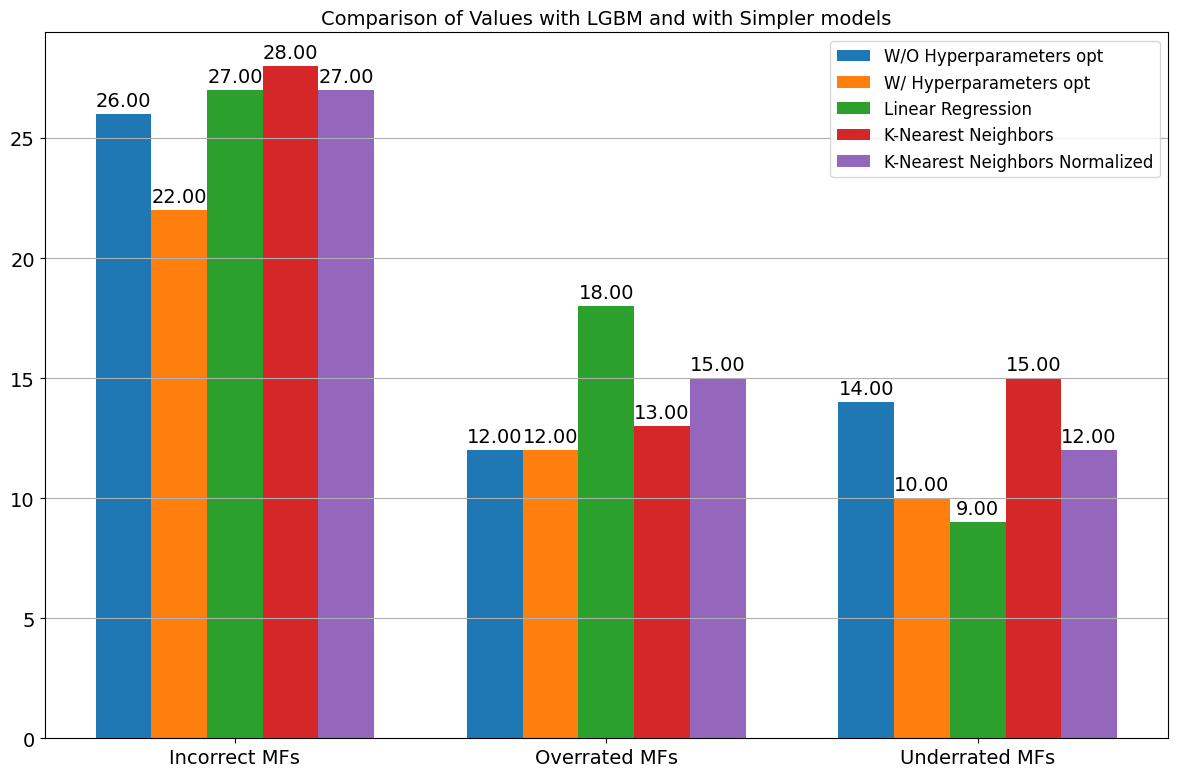

In [ ]:
# Define labels for each pair of values
labels = ['Incorrect MFs', 'Overrated MFs', 'Underrated MFs']

# Create an array with positions of the bars
x = np.arange(len(labels))  # the label locations

# Define the width of the bars
width = 0.15  # the width of the bars (adjusted for 5 bars)


fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
bars1 = ax.bar(x - 2*width, p1, width, label='W/O Hyperparameters opt')
bars2 = ax.bar(x - width, p1_cross, width, label='W/ Hyperparameters opt')
bars3 = ax.bar(x, p1_lr_cross, width, label='Linear Regression')
bars4 = ax.bar(x + width, p1_kn_cross, width, label='K-Nearest Neighbors')
bars5 = ax.bar(x + 2*width, p1_kn_norm, width, label='K-Nearest Neighbors Normalized')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Comparison of Values with LGBM and with Simpler models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)
add_value_labels(bars5)

# Adjust layout
fig.tight_layout()
plt.grid(axis='y')
plt.savefig(res_folder+"COMPARISON_LGBM_SIMPLER_MODELS.png")

# Show the plot
plt.show()


With this graph we can esaily see that the LGBM regressor has a much better performance than the simpler modesl considered in this trial.

### 3.6 Testing on German

In this section we would like to answer the question:
"Given a model trained on the european sataset can we how well can we predict the modulation format on a different dataset".

In [ ]:
datafile = 'Dataset_german_17_node1.dat'

spans, link_occ, snr_values = read_dataset(datafile)
X_german = extract_features(spans, link_occ)
y_german = np.array(snr_values)
y_modulation_test = [SNR_to_MF(i) for i in y_german]

In [ ]:
y_snr_pred_low,y_snr_pred_high,training_duration = lgbm_regr(X_train, X_german, y_train, y_german)
y_modulation_pred = calculate_metrics(y_snr_pred_low,y_snr_pred_high, y_german, y_modulation_test, True)
pgerman_cross=pred_values_lgbm_reg(y_modulation_pred,y_modulation_test)

DONE
Mean Squared Error: 0.16
Mean Absolute Error: 0.30
Accuracy: 0.86
Precision: 0.81
Recall: 0.86
F1-score: 0.83
Number of incorrectly-assigned MFs: 42
Number of overrated MFs: 17
Number of underrated MFs: 25


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With this test we can see that using the European Dataset as training and testing on the German one, we got an accuracy of 86%. Not as accurate as test on the same dataset, but still not that bad MFs predictions.

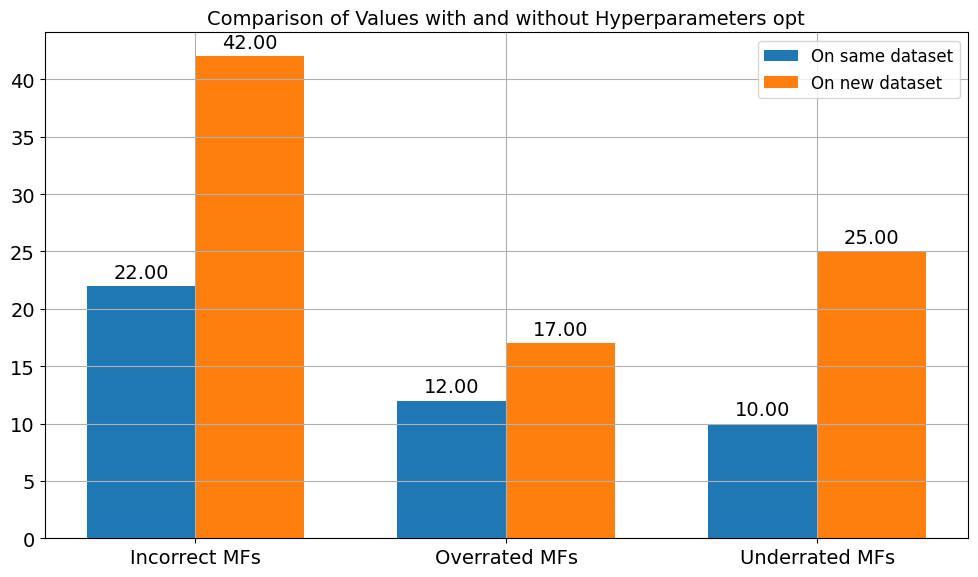

In [ ]:
# Define labels for each pair of values
labels = ['Incorrect MFs', 'Overrated MFs', 'Underrated MFs']

# Create an array with positions of the bars
x = np.arange(len(labels))  # the label locations

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
bars1 = ax.bar(x - width/2, p1_cross, width, label='On same dataset')
bars2 = ax.bar(x + width/2, pgerman_cross, width, label='On new dataset')


ax.set_title('Comparison of Values with and without Hyperparameters opt')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


add_value_labels(bars1)
add_value_labels(bars2)


fig.tight_layout()
plt.grid()
# Show the plot
plt.savefig(res_folder+f'COMPARISON_TESTING_ON_GERMAN.png')
plt.show()


### 3.7 Explaniable AI

We will see the relationship between the features using XAI to make sure that the model takes correct decisions based on correct reasons

In [ ]:
# Install a specific version of the shap library
!pip install shap==0.42.1

import shap
print(shap.__version__)
import shap.plots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.6 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


0.42.1


We start obtaining the shap values for the lgbm regressors for high and low quantile, and get the mean of these  results.

In [ ]:
#set number of shap points to consider with SHAP, we can consider the whole dataset
shappoints = 1833

# Calculate SHAP values for both models
explainer_low = shap.TreeExplainer(snr_regressor_low)
explainer_high = shap.TreeExplainer(snr_regressor_high)

shap_values_low = explainer_low.shap_values(X[:shappoints])
shap_values_high = explainer_high.shap_values(X[:shappoints])

# Ensure the SHAP values have the same shape
assert shap_values_low.shape == shap_values_high.shape, "SHAP values must have the same shape."

# Average the SHAP values
mean_shap_values = np.array([np.mean([shap_values_low[i], shap_values_high[i]], axis=0) for i in range(len(shap_values_high))])
mean_shap_values


array([[ 2.23366122e-01, -1.11698868e+00, -3.00485449e-02,
        -2.61859706e-02,  5.35251762e-02,  7.29268131e-02],
       [ 5.75253753e-03,  1.04361090e+00, -3.25358429e-02,
         2.86816948e-02,  7.19451362e-02, -2.28414543e-02],
       [ 8.35077387e-02, -1.65826791e+00, -2.34239683e-02,
        -4.42096258e-02,  3.70181973e-03,  4.86807734e-02],
       ...,
       [ 1.48514218e-02, -1.28815943e+00, -3.00580809e-02,
        -2.84420970e-01, -1.27349257e-01,  2.67097732e-02],
       [-3.17723304e-02,  1.98409771e+00, -2.89862847e-02,
         9.99024299e-02, -7.87185597e-02, -2.63555424e-01],
       [-1.95987823e-02,  6.91017835e-01, -3.41347378e-02,
        -1.64635378e-03,  1.10480594e-02, -4.53099917e-03]])

#### Global summary plot

For this method, as we use lgbm only as a regressor, we can only plot the Global summary of the SNR values predicted, because the MFs are later mapped with the corresponding conversion, which is no longer attached with the lgbm.

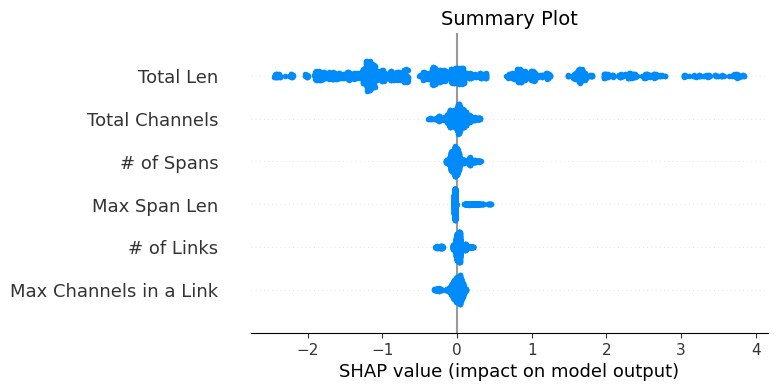

<Figure size 640x480 with 0 Axes>

In [ ]:
lista=['# of Spans','Total Len','Max Span Len','# of Links', 'Total Channels','Max Channels in a Link']

# Plot the SHAP summary plot
shap.summary_plot(mean_shap_values, feature_names=lista, show=False, max_display=10)
plt.title("Summary Plot")
plt.show()
plt.savefig(res_folder+f'SHAP_EUROPEAN_1.png')

With this plot, we can see that the value of the predicted SNR depends very highly on the feature "Total Len", something expected for a lightpath.

Also, as concluded from the graphs, the second and third more impactful features were "Total Channels" (means some interference on the lighpath takes place) and the "# of Spans" (means the introduction of more Optical Amplifiers that introduce more AES noise that degrades the SNR).


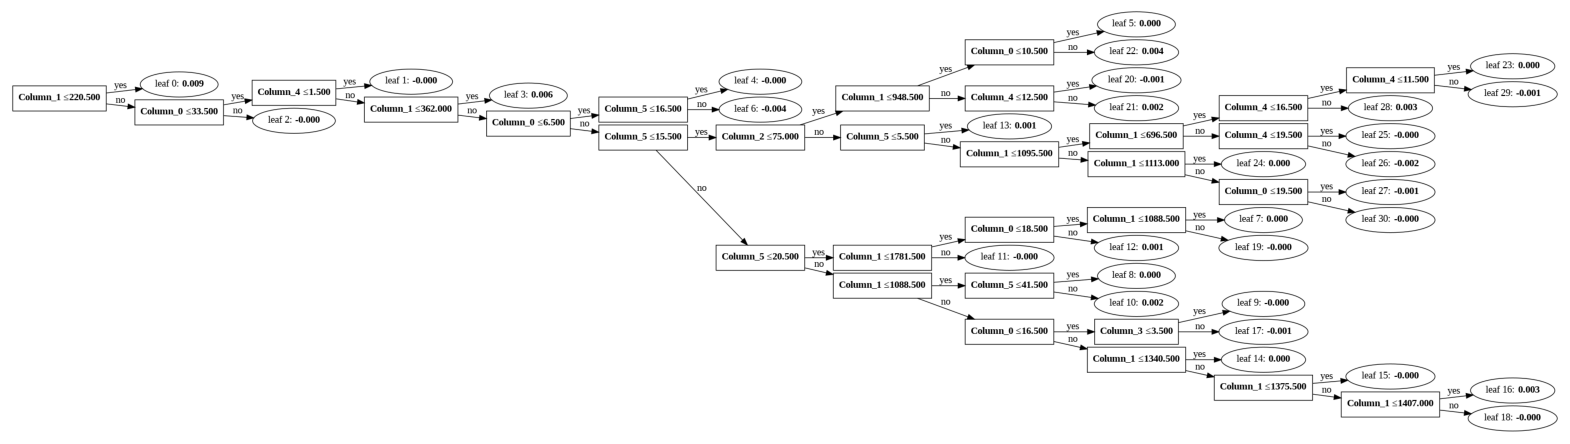

In [ ]:
lgb.plot_tree(snr_regressor_low, tree_index=99, figsize=(20, 10))
plt.show()

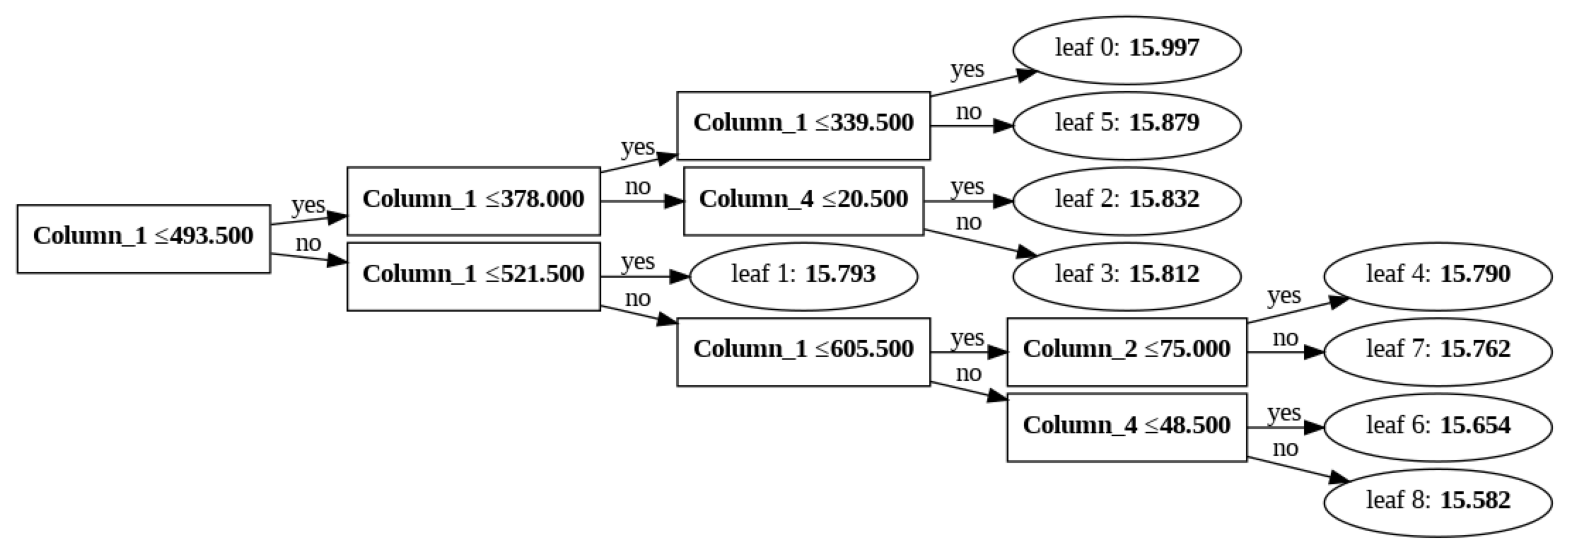

In [ ]:
lgb.plot_tree(snr_regressor_high, tree_index=0, figsize=(20, 10))
plt.show()

## 4. Part2 LGBM as Classifier
Using directly LGBM as classifier to predict MF.

### 4.1 ML optimization and training

We do the crossvalidation technique once again, to get the best parameters for the algorithm.

In [ ]:
# Convert SNR values to modulation formats for ground truth labels
y_modulation = np.array([SNR_to_MF(snr) for snr in y])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test=split_dataset(X,y_modulation)


In [ ]:
def optimize_lgbm_classifier():
    # Define the parameter distributions for random search
    param_dist = {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 4, 5, -1],  # -1 means no limit
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [20, 31, 40],
        'min_child_samples': [20, 30, 40],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0, 0.1, 1],
        'verbosity':[-1]
    }

    # Initialize the LGBMClassifier
    model = lgb.LGBMClassifier(random_state=42)

    # Define the scorer
    scorer = make_scorer(f1_score, average='weighted')

    # Initialize RandomizedSearchCV
    rand_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring=scorer, cv=5, n_jobs=-1, random_state=42, verbose=1)
    #rand_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring=scorer, cv=10, random_state=42, verbose=1)

    # Perform random search
    rand_search.fit(X_train, y_train)

    # Print best parameters and best score
    #print("Best parameters found: ", rand_search.best_params_)
    #print("Best cross-validation score (F1): ", rand_search.best_score_)

    # Get the best model
    best_model = rand_search.best_estimator_

    # Train the best model on the entire training set
    best_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = best_model.predict(X_test)

    # Print best parameters and best score
    print("Best parameters found: ", rand_search.best_params_)
    print("Best cross-validation score (F1): ", rand_search.best_score_)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Output results
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')

    return rand_search.best_params_

#apply the function
best_params = optimize_lgbm_classifier()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


The least populated class in y has only 3 members, which is less than n_splits=5.


Best parameters found:  {'verbosity': -1, 'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0, 'num_leaves': 20, 'n_estimators': 100, 'min_child_samples': 30, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best cross-validation score (F1):  0.9328649650115446
Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1-score: 0.93


### 4.2 Without Hyperparameters optimization

First do the procedure straighforward, without the cross validation.

Create a function to define the use of LGBM as the classifier.

In [ ]:
def lgbm_clas(X_train, X_test, y_train, y_test):
  # Define the LightGBM classifier
  modulation_classifier = lgb.LGBMClassifier()

# Train the classifier
  start_time = time.time()
  modulation_classifier.fit(X_train, y_train)
  training_duration = time.time() - start_time

  # Predict modulation formats on the test set
  y_pred = modulation_classifier.predict(X_test)

# Evaluate the classifier
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')

  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)

# Output results
  print(f'Training Duration: {training_duration:.2f} seconds')
  print(f'Mean Squared Error: {mse:.2f}')
  print(f'Mean Absolute Error: {mae:.2f}')
  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1-score: {f1:.2f}')

  return y_pred

In [ ]:
y_pred = lgbm_clas(X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 6
[LightGBM] [Info] Start training from score -0.911867
[LightGBM] [Info] Start training from score -0.828825
[LightGBM] [Info] Start training from score -1.834972
[LightGBM] [Info] Start training from score -6.191681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

Save the values of errors for this method without hyperparameters optimization

In [ ]:
p2=pred_values_lgbm_reg(y_pred,y_test)

Number of incorrectly-assigned MFs: 25
Number of overrated MFs: 10
Number of underrated MFs: 15


### 4.3 Using the Best Parameters found

Retry the procedure, but with the hyperparameters found.

In [ ]:
# Initialize the LightGBM classifier with best parameters
modulation_classifier = lgb.LGBMClassifier(**best_params, random_state=42)

# Train the classifier
modulation_classifier.fit(X_train, y_train)
# Predict modulation formats on the test set
y_pred = modulation_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Output results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1-score: 0.93


In [ ]:
p2_cross=pred_values_lgbm_reg(y_pred,y_test)

Number of incorrectly-assigned MFs: 24
Number of overrated MFs: 11
Number of underrated MFs: 13


In [ ]:
print(p2)
print(p2_cross)

[25, 10, 15]
[24, 11, 13]


This time the optimization of the hyperparameters improved the process by just 1 less incorrectly assigned MFs overall.

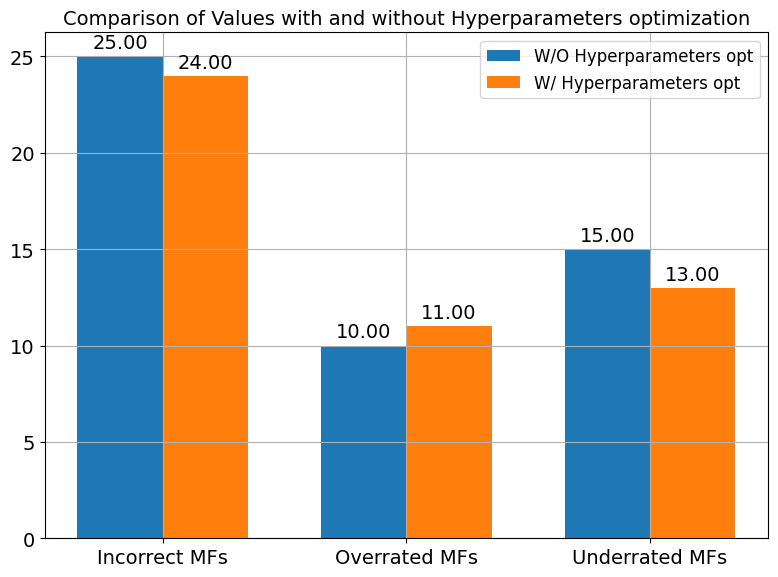

In [ ]:
# Define labels for each pair of values
labels = ['Incorrect MFs', 'Overrated MFs', 'Underrated MFs']

# Create an array with positions of the bars
x = np.arange(len(labels))  # the label locations

# Define the width of the bars
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6))

# Plot the data
bars1 = ax.bar(x - width/2, p2, width, label='W/O Hyperparameters opt')
bars2 = ax.bar(x + width/2, p2_cross, width, label='W/ Hyperparameters opt')

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_title('Comparison of Values with and without Hyperparameters optimization')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
add_value_labels(bars1)
add_value_labels(bars2)

# Adjust layout
fig.tight_layout()
plt.grid()
plt.savefig(res_folder+"COMPARISON_EUROPEAN_2.png")
# Show the plot
plt.show()

### 4.4 Simpler models

In this method we don't need to take into account quantiles, so we use the LogisticRegression and KNeighborsClassifier from the scikit-learn library

#### 4.4.1 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the Logistic Regression classifier
logistic_classifier = LogisticRegression(random_state=42, max_iter=1000)

# Train the classifier
logistic_classifier.fit(X_train, y_train)

# Predict modulation formats on the test set
y_pred_logistic = logistic_classifier.predict(X_test)

# Evaluate the classifier
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic, average='weighted')
recall_logistic = recall_score(y_test, y_pred_logistic, average='weighted')
f1_logistic = f1_score(y_test, y_pred_logistic, average='weighted')

# Output results
print('Logistic Regression:')
print(f'Accuracy: {accuracy_logistic:.2f}')
print(f'Precision: {precision_logistic:.2f}')
print(f'Recall: {recall_logistic:.2f}')
print(f'F1-score: {f1_logistic:.2f}')


Logistic Regression:
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1-score: 0.90


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
p2_logr_cross=pred_values_lgbm_reg(y_pred_logistic,y_test)

Number of incorrectly-assigned MFs: 35
Number of overrated MFs: 17
Number of underrated MFs: 18


The Logistic regressor gave worse results than with the LGBM, having now only 90% accuracy.

Let's see with KNN.

#### 4.4.2 K_Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the K-Nearest Neighbors classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Predict modulation formats on the test set
y_pred_knn = knn_classifier.predict(X_test)

# Evaluate the classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

# Output results
print('K-Nearest Neighbors:')
print(f'Accuracy: {accuracy_knn:.2f}')
print(f'Precision: {precision_knn:.2f}')
print(f'Recall: {recall_knn:.2f}')
print(f'F1-score: {f1_knn:.2f}')


K-Nearest Neighbors:
Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1-score: 0.93


In [ ]:
p2_knn_cross=pred_values_lgbm_reg(y_pred_knn,y_test)

Number of incorrectly-assigned MFs: 27
Number of overrated MFs: 16
Number of underrated MFs: 11


The KNN classifier gave a better result than the previous model, but still the LGBM has a more accurate performnace.

#### 4.4.3 KNN+NORMALIZATION

In [ ]:
#Normalize X
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

display (X_train_scaled)
#display (y_train_scaled)
display (X_test_scaled)
#display (y_test_scaled)

# Initialize the K-Nearest Neighbors classifier
knn_classifier_norm = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_classifier_norm.fit(X_train_scaled, y_train)

# Predict modulation formats on the test set
y_pred_knn_norm = knn_classifier_norm.predict(X_test_scaled)

# Evaluate the classifier
accuracy_knn_norm = accuracy_score(y_test, y_pred_knn_norm)
precision_knn_norm = precision_score(y_test, y_pred_knn_norm, average='weighted')
recall_knn_norm = recall_score(y_test, y_pred_knn_norm, average='weighted')
f1_knn_norm = f1_score(y_test, y_pred_knn_norm, average='weighted')

# Output results
print('K-Nearest Neighbors:')
print(f'Accuracy: {accuracy_knn_norm:.2f}')
print(f'Precision: {precision_knn_norm:.2f}')
print(f'Recall: {recall_knn_norm:.2f}')
print(f'F1-score: {f1_knn_norm:.2f}')

array([[0.36111111, 0.43333333, 0.66666667, 0.        , 0.08130081,
        0.2173913 ],
       [0.19444444, 0.17333333, 0.66666667, 0.2       , 0.17073171,
        0.36956522],
       [0.38888889, 0.43333333, 1.        , 0.4       , 0.37398374,
        0.60869565],
       ...,
       [0.38888889, 0.46      , 1.        , 0.4       , 0.58536585,
        0.91304348],
       [0.22222222, 0.28333333, 1.        , 0.2       , 0.13821138,
        0.2826087 ],
       [0.66666667, 0.74666667, 1.        , 0.6       , 0.34146341,
        0.34782609]])

array([[0.44444444, 0.57666667, 1.        , 0.4       , 0.32520325,
        0.60869565],
       [0.25      , 0.34333333, 1.        , 0.2       , 0.43902439,
        0.76086957],
       [0.27777778, 0.3       , 1.        , 0.2       , 0.16260163,
        0.2173913 ],
       ...,
       [0.22222222, 0.28666667, 1.        , 0.2       , 0.37398374,
        0.76086957],
       [0.66666667, 0.74666667, 1.        , 0.8       , 0.60162602,
        0.54347826],
       [0.08333333, 0.11666667, 1.        , 0.        , 0.11382114,
        0.30434783]])

K-Nearest Neighbors:
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1-score: 0.92


In [ ]:
p2_knn_norm=pred_values_lgbm_reg(y_pred_knn_norm,y_test)

Number of incorrectly-assigned MFs: 31
Number of overrated MFs: 18
Number of underrated MFs: 13


On this case, the normalization made the results worse. We can check the comparison of the models on the following graph.

### 4.5 Comparison Simpler Models vs LGBM

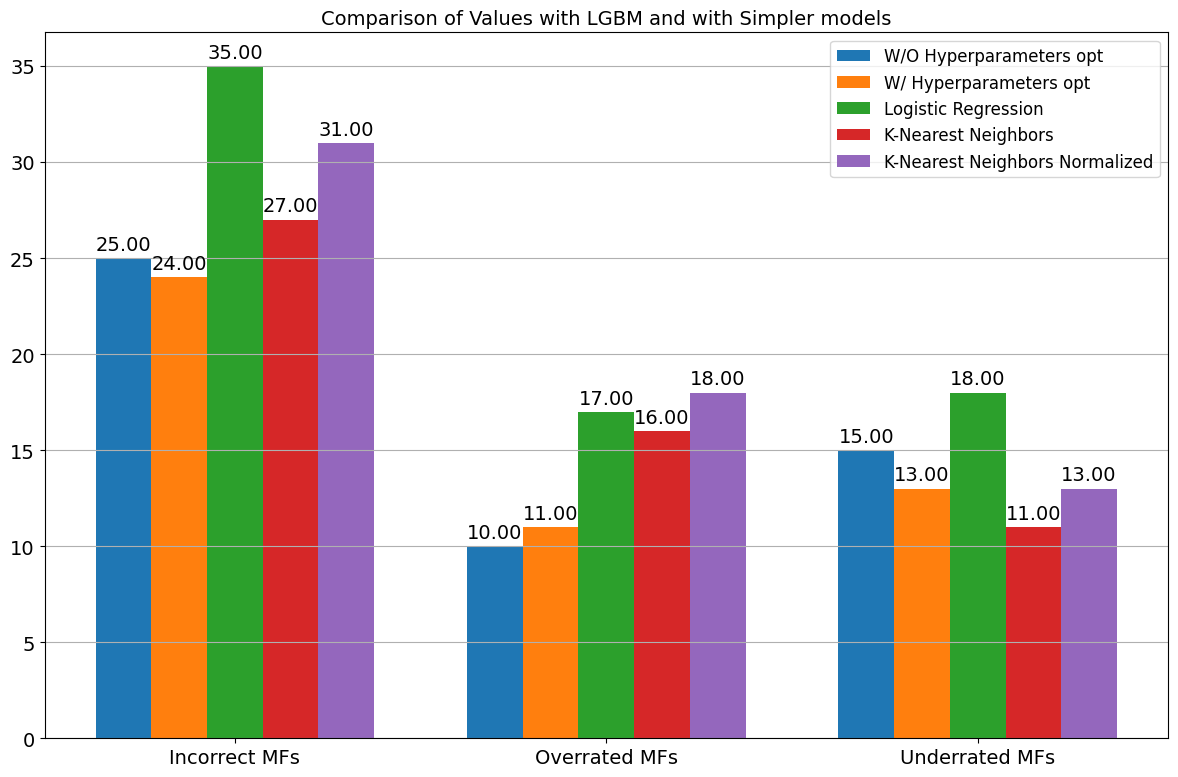

In [ ]:

# Define labels for each pair of values
labels = ['Incorrect MFs', 'Overrated MFs', 'Underrated MFs']

# Create an array with positions of the bars
x = np.arange(len(labels))  # the label locations

# Define the width of the bars
width = 0.15  # the width of the bars (adjusted for 5 bars)


fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
bars1 = ax.bar(x - 2*width, p2, width, label='W/O Hyperparameters opt')
bars2 = ax.bar(x - width, p2_cross, width, label='W/ Hyperparameters opt')
bars3 = ax.bar(x, p2_logr_cross, width, label='Logistic Regression')
bars4 = ax.bar(x + width, p2_knn_cross, width, label='K-Nearest Neighbors')
bars5 = ax.bar(x + 2*width, p2_knn_norm, width, label='K-Nearest Neighbors Normalized')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Comparison of Values with LGBM and with Simpler models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)
add_value_labels(bars5)

# Adjust layout
fig.tight_layout()
plt.grid(axis='y')
plt.savefig(res_folder+"COMPARISON_LGBM_SIMPLER_MODELS_2.png")

# Show the plot
plt.show()



As a conclusion, the LGBM classifer has proven to be an excellent choice for our model, in comparsion to the simpler models shown.

### 4.6 Explaniable AI

We will see the relationship between the features using XAI to make sure that the model takes correct decisions based on correct reasons

In [ ]:
#set number of shap points to consider with SHAP, we can consider the whole dataset
shappoints = 1833

#create and initialize explainer, we use TreeExplainer and pass the modulation classifier as an argument
explainer_shap = shap.TreeExplainer(modulation_classifier)

#Calculating the SHAP values by using shap_values method. It takes training data as an argument
shap_values = explainer_shap.shap_values(X[:shappoints])

#shap_values

# Get the class labels from the classifier
class_labels = modulation_classifier.classes_

# Print the class labels and corresponding SHAP values arrays
for label, shap_value in zip(class_labels, shap_values):
    print(f"Class label: {label}")
    print(shap_value)

Class label: 4
[[-7.03243843e-01  2.93710215e+00  1.67854928e-03 -2.27639056e-02
  -1.45068165e-01 -2.48842701e-01]
 [ 1.81691735e-01 -3.11858779e+00  8.12602918e-04 -1.91422197e-01
  -1.67311503e-01  2.91663317e-02]
 [-2.55687332e-01  3.73403288e+00  3.03813085e-03  3.46941120e-01
  -4.82625744e-02  8.10012037e-03]
 ...
 [-1.31742955e-01  3.53907455e+00  3.95109362e-03  5.84074347e-01
   5.61263973e-01  5.40707728e-02]
 [ 1.59256934e-01 -3.13079787e+00  8.21748498e-04 -2.36006573e-01
  -1.13426340e-02  3.67199458e-01]
 [ 1.47689016e-01 -3.18587588e+00  8.21748498e-04 -3.74503794e-03
  -7.83053008e-02 -1.42590298e-01]]
Class label: 8
[[ 1.12971139e+00 -1.03662834e+00  2.14611045e-03  5.83472742e-03
   1.73422679e-01  1.57474954e-01]
 [-6.52290394e-02  2.26615295e+00  1.42567634e-02  2.05296124e-01
   8.78952446e-04  5.59516296e-02]
 [ 1.74313441e-01 -2.64058915e+00 -3.78930968e-03 -6.06303705e-01
  -7.70883241e-02 -6.73654364e-02]
 ...
 [ 1.87204865e-01 -2.01710226e+00 -2.64396351e-03 

#### Global summary plot

We show first the plot of all the predicted MFs, and the overall relationship of the prediction with the features of the lightpath. Now, as we use LGBM as a classifier, we can show the various types of MFs and not only raw SNR values.

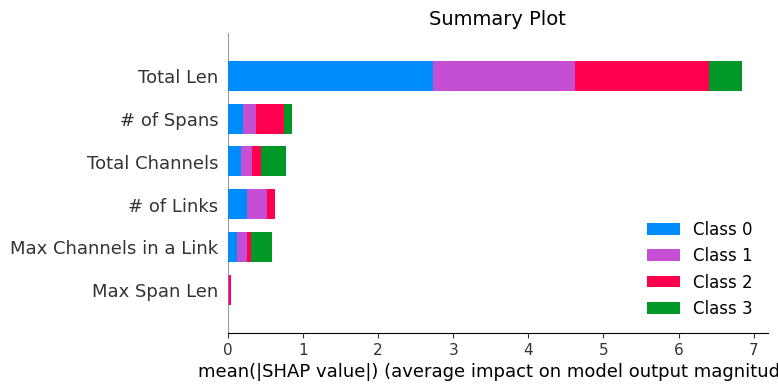

In [ ]:
lista=['# of Spans','Total Len','Max Span Len','# of Links', 'Total Channels','Max Channels in a Link']

shap.summary_plot(shap_values, feature_names=lista, show = False, max_display=10)
plt.title("Summary Plot")
plt.savefig(res_folder+"Summary_plot_european_2.png")
plt.show()

With this summary plot it can be seen that, the feature "Total Len" is, by a considerable margin, the most influential feature of the algorithm prediction.

Another important conclusion is that, the feature "Max Span Len" is almost not influential in the prediction, only affecting to the Class 2 MF.

The other features do influent in the decision of the prediction, but still not as heavy as the "Total Len".

#### Summary plot for each class of modulation found

For this method we posses different MFs (classes) predicted, which allows us to create summary plots of the influence of the lightpath features on each of the MF selected.

In [ ]:
# Find the number of distinct labels and make a list of distinct labels
n_label = len(set(y_modulation))
labels = list(set(y_modulation))

print(n_label)
print(labels)
print(class_labels )

4
[8, 16, 64, 4]
[ 4  8 16 64]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


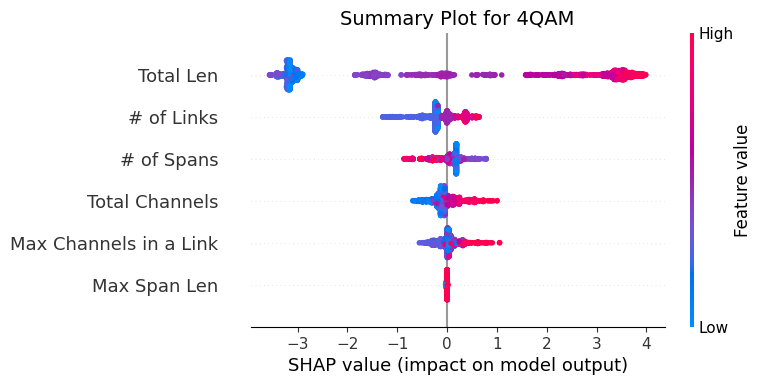

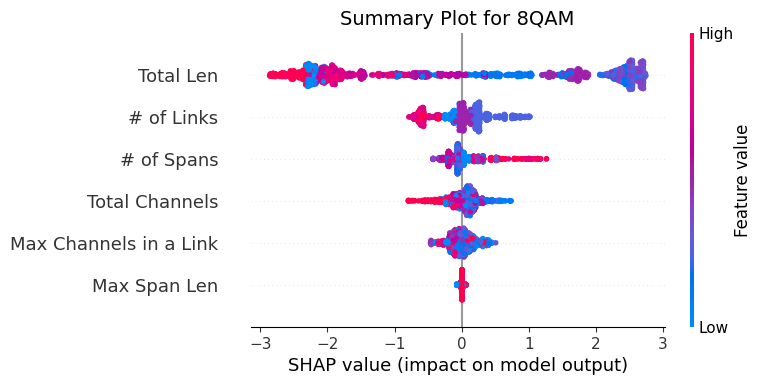

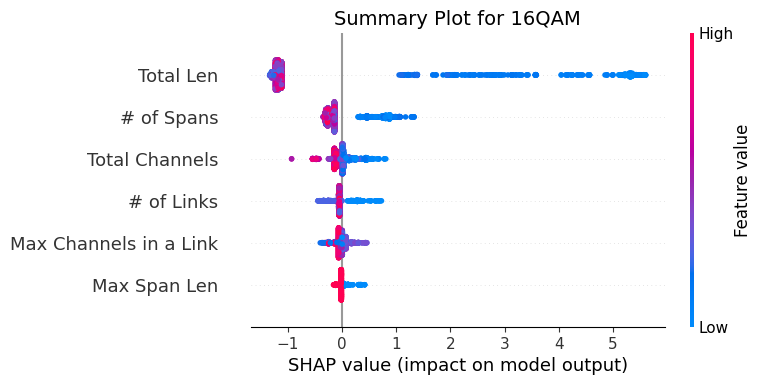

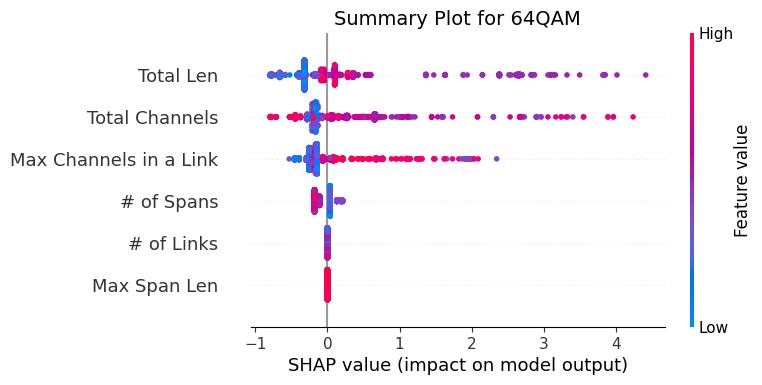

In [ ]:
#4 (QPSK), 8 (8QAM), 16 (16QAM), 32 (32QAM), 64 (64QAM)

class_name = ['4QAM','8QAM', '16QAM' , '64QAM']

#Iterate over labels (classes) and plot SHAP's summary plot of each label using shap.summary_plot method
#method takes shap_values of the class, data set (from this SHAP gets features' values) and features names
#in addition to the number of features to display
#we use show = False so the figure is not directly plotted so we can add a unique title to it in a next step
for class_ind in range(n_label):
    shap.summary_plot(shap_values[class_ind], features=X[:shappoints], feature_names=lista,
                      show = False, max_display=10)

    title = 'Summary Plot for ' + str(class_name[class_ind])
    plt.title(title)
    plt.savefig(res_folder+f"SHAP_{class_name[class_ind]}_EUROPEAN.png")
    plt.show()

With these plots for each MF, we can see the impact of the impact of the features in the prediction of each class. As expected, the "Total Len" is the most influential feature on every MF.

As commented before, the "Max Span Len" feature seems to be important only for one MF (16QAM), and not in a really significant manner; so maybe this is one feature that could be neglected in following trials of the algorithm.

In addition, for the highest of MF (64QAM) it can be appreciated that more features, like "Total Channels" and "Max Channels in a Link", take a more considerable effect on the predction. This is due to the fact that, gaining high values of SNR (that allows the use of this MF) seem to take great impact of the interference factor on the lightpath, which these features seem to describe.

## 5. Comparison of both methods

Now we compare the two methods using a graph similar to the previous ones.

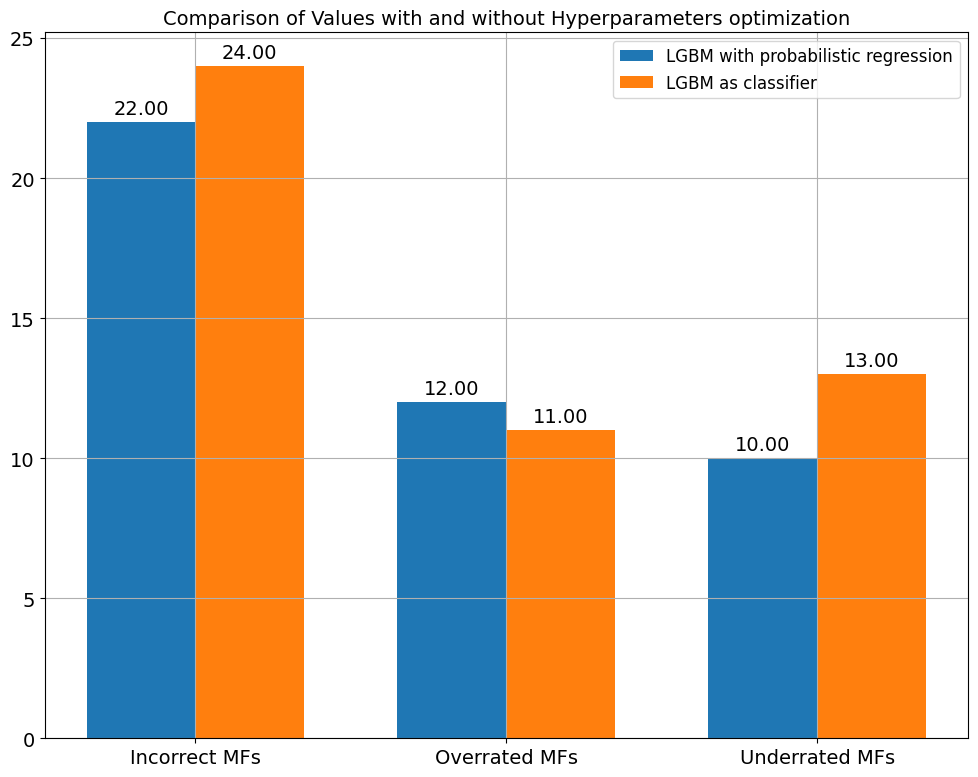

In [ ]:
# Define labels for each pair of values
labels = ['Incorrect MFs', 'Overrated MFs', 'Underrated MFs']

# Create an array with positions of the bars
x = np.arange(len(labels))  # the label locations

# Define the width of the bars
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10,8))

# Plot the data
bars1 = ax.bar(x - width/2, p1_cross, width, label='LGBM with probabilistic regression')
bars2 = ax.bar(x + width/2, p2_cross, width, label='LGBM as classifier')

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_title('Comparison of Values with and without Hyperparameters optimization')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
add_value_labels(bars1)
add_value_labels(bars2)

# Adjust layout
fig.tight_layout()
plt.grid()
plt.savefig(res_folder+"Comparison_classifier_prob_EUROPEAN.png")
# Show the plot
plt.show()

For this dataset, we got as a result that using the LGBM with a probabilistic regresion of low/high-quantile estimations of SNR produced less incorrectly assigned MFs than when using the LGBM directly as a classifier of MFs.

Nonetheless, both techniques can be seen as having high accuracy (0.94 and 0.93) and valid for use of determining the MF according to path features data.

# GERMAN NODES

Now, we try and replicate the process with the second datafile, the one representing the nodes in Germany.

## 1. Raw data visualization and analysis

Again, you can skip the next line if you have the final file we send.

In [ ]:
datafile = 'Dataset_german_17_node1.dat'

spans, link_occ, snr_values = read_dataset(datafile)

print('Length of span list: ' +str(len(spans)))
print('Length of link occupancy list: ' +str(len(link_occ)))
print('Length of SNR list: ' +str(len(snr_values)))


Length of span list: 1672
Length of link occupancy list: 1672
Length of SNR list: 1672


## 2. Data preprocessing

In [ ]:
calculate_m_v_s(spans, link_occ, snr_values)

**********
Number of spans: mean=7.19, var=9.67, std=3.11
Lightpath length: mean=439.98, var=38192.79, std=195.43
Number of channels in links: mean=59.03, var=2126.51, std=46.11
SNR: mean=15.67, var=1.65, std=1.28
**********


In [ ]:
X = extract_features(spans, link_occ)
#display(X)
print('Shape of features matrix: '+str(X.shape))

Shape of features matrix: (1672, 6)


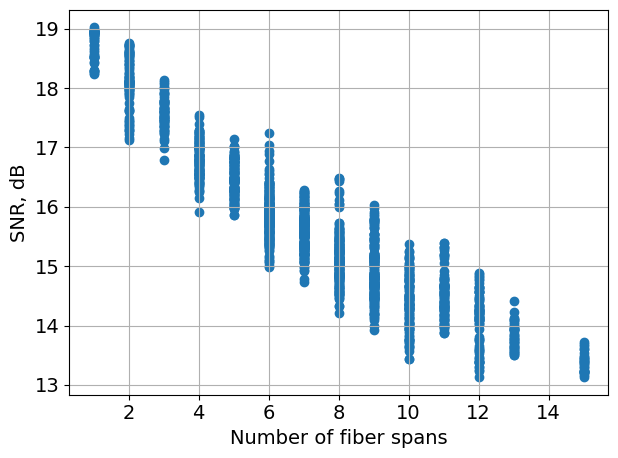

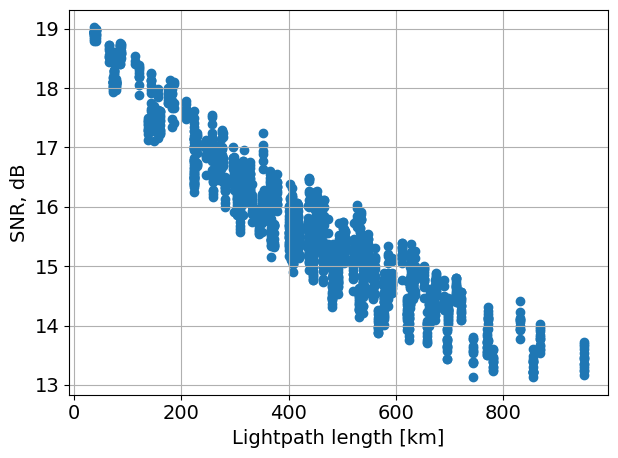

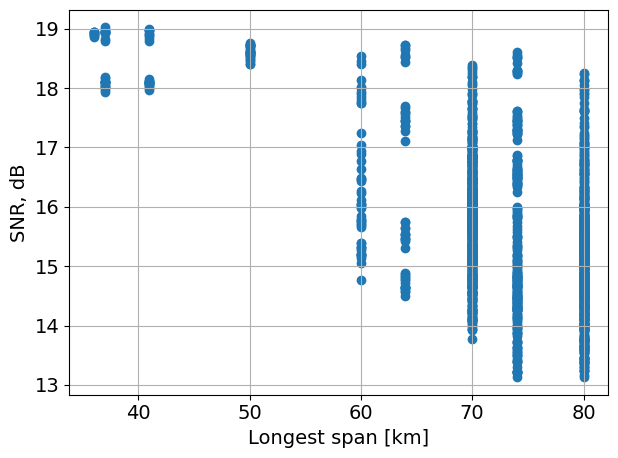

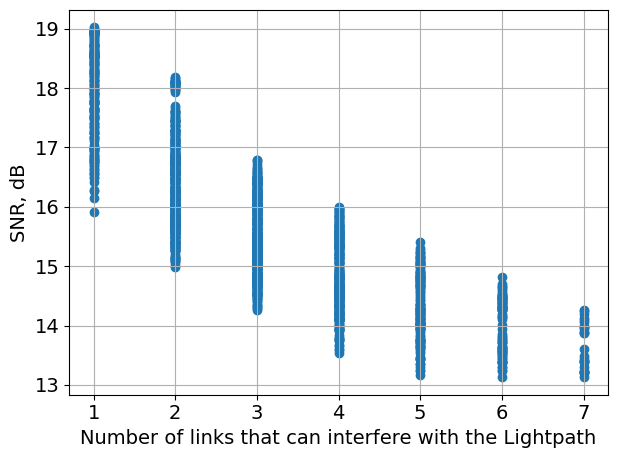

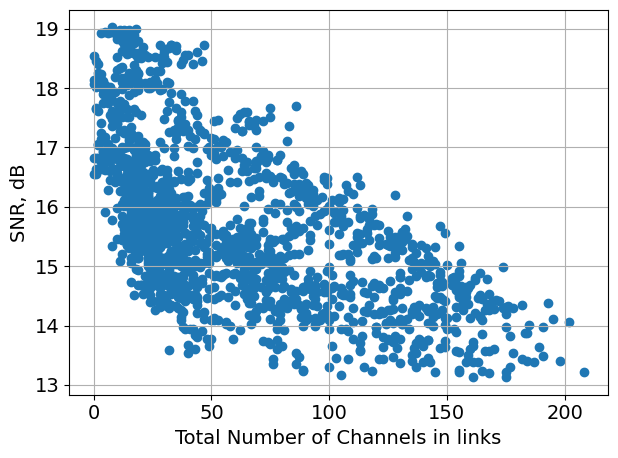

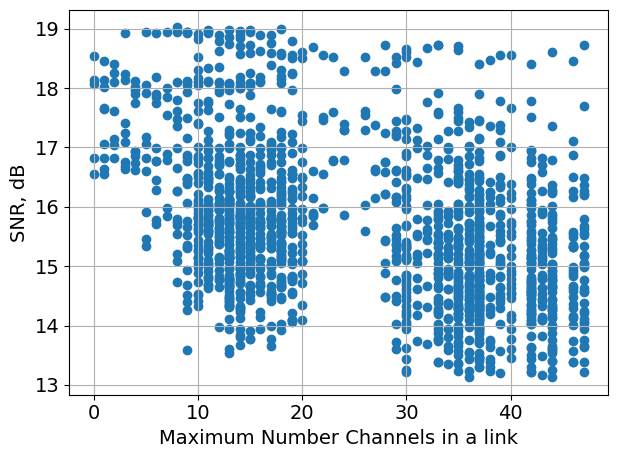

In [ ]:
#F: figure settings to improve readability (customize as you prefer)

FONT_SIZE = 14
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)     # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title

#F: if you want to save figures in a proper directory, uncomment the commented lines below
#res_folder = 'Results'
#if not os.path.exists(res_folder):
#    os.makedirs(res_folder)


x_labels = ['Number of fiber spans', 'Lightpath length [km]', 'Longest span [km]',
            'Number of links that can interfere with the Lightpath',
            'Total Number of Channels in links',
            'Maximum Number Channels in a link',
            ]


for i in range(X.shape[1]):

  plt.scatter(X[:, i], snr_values)
  plt.xlabel(x_labels[i])
  plt.ylabel('SNR, dB')
  plt.grid()
  plt.tight_layout()
  plt.savefig(res_folder+f'GERMAN_FEATURES_{x_labels[i]}.png')
  plt.show()


The Feature "Length of the lightpath"and "Number of Fiber Spans" are inversely proportional with respect to the SNR of the link. The "Number of channels" also follow this relation, but not as strong.

The other features don't give a strong or clear relationship with respect to the value of the SNR.

## 3. Part1 LGBM as a Regressor with Probabilistic Regression
Use probabilistic regression and assign MF based on low/high-quantile estimations of SNR.

Using LGBM as regressor, LightGBM can be configured to predict quantiles using the objective parameter set to quantile.


### 3.1 ML optimization and training
We do the crossvalidation technique to get the best parameters for the Algorithm.

In [ ]:
y = np.array(snr_values)#define y
X_train, X_test, y_train, y_test=split_dataset(X,y)#split the dataset

#get the best parameters
best_params_l = optimize_h_lgbm(0.1)
best_params_h = optimize_h_lgbm(0.9)

print('ecco',best_params_l)
print('ecco',best_params_h)

Best parameters found:  {'verbosity': -1, 'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'quantile', 'num_leaves': 20, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'alpha': 0.1}
Best cross-validation score (MSE):  0.07429246046690137
Training MSE:  0.06262674017852915
Best parameters found:  {'verbosity': -1, 'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'quantile', 'num_leaves': 20, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'alpha': 0.9}
Best cross-validation score (MSE):  0.07427934585470368
Training MSE:  0.066471056264948
ecco {'verbosity': -1, 'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'quantile', 'num_leaves': 20, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'alpha': 0.1}
ecco {'verbosity': -1, 'subsample': 1.0, 'reg_lambda': 0, '

### 3.2 Without Hyperparameters optimization

First do the procedure straighforward, without the cross validation.

In [ ]:
# Convert SNR values to modulation formats for ground truth labels

y_modulation_train = [SNR_to_MF(i) for i in y_train]
y_modulation_test = [SNR_to_MF(i) for i in y_test]

# Define the LightGBM regressor for quantile regression
params = {
    'objective': 'quantile',
    'alpha': 0.1,  # For 10th percentile
    'verbosity':[-1]
}
start_time = time.time()
snr_regressor_low = lgb.LGBMRegressor(**params)
snr_regressor_low.fit(X_train, y_train)

params['alpha'] = 0.9  # For 90th percentile
snr_regressor_high = lgb.LGBMRegressor(**params)
snr_regressor_high.fit(X_train, y_train)
training_duration = time.time() - start_time

# Predict SNR values on the test set
y_snr_pred_low = snr_regressor_low.predict(X_test)
y_snr_pred_high = snr_regressor_high.predict(X_test)

print("DONE")

DONE


Get the metrics.

In [ ]:
y_modulation_pred = calculate_metrics(y_snr_pred_low,y_snr_pred_high, y_test, y_modulation_test,True)

Mean Squared Error: 0.04
Mean Absolute Error: 0.15
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1-score: 0.95


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
p1g=pred_values_lgbm_reg(y_modulation_pred,y_modulation_test)

Number of incorrectly-assigned MFs: 17
Number of overrated MFs: 8
Number of underrated MFs: 9


### 3.3 Using the Best Parameters found

Now do the technique, but with the best parameters found for low and high quartiles.

In [ ]:
params1 = best_params_l
params2 = best_params_h
y_snr_pred_low,y_snr_pred_high,training_duration = lgbm_regr(X_train, X_test, y_train, y_test)

DONE


In [ ]:
y_modulation_pred = calculate_metrics(y_snr_pred_low,y_snr_pred_high, y_test, y_modulation_test,True)

Mean Squared Error: 0.04
Mean Absolute Error: 0.15
Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1-score: 0.96


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
p1g_cross=pred_values_lgbm_reg(y_modulation_pred,y_modulation_test)

Number of incorrectly-assigned MFs: 14
Number of overrated MFs: 5
Number of underrated MFs: 9


In [ ]:
print(p1g)
print(p1g_cross)

[17, 8, 9]
[14, 5, 9]


Once again, using the cross validation gives a better accuracy of the procedure (from 0.95 to 0.96), which can be seen better on the graph below, having now 3 less incorreclty-assigned MFs with the hyperparameters.

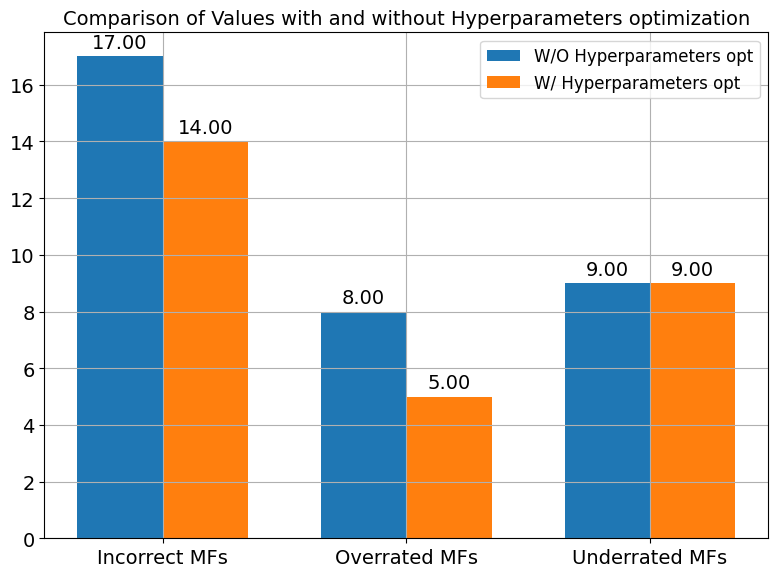

In [ ]:
# Define labels for each pair of values
labels = ['Incorrect MFs', 'Overrated MFs', 'Underrated MFs']

# Create an array with positions of the bars
x = np.arange(len(labels))  # the label locations

# Define the width of the bars
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6))

# Plot the data
bars1 = ax.bar(x - width/2, p1g, width, label='W/O Hyperparameters opt')
bars2 = ax.bar(x + width/2, p1g_cross, width, label='W/ Hyperparameters opt')

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_title('Comparison of Values with and without Hyperparameters optimization')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
add_value_labels(bars1)
add_value_labels(bars2)

# Adjust layout
fig.tight_layout()
plt.grid()
plt.savefig(res_folder+"COMPARISON_GERMAN_1.png")
# Show the plot
plt.show()


### 3.4 Simpler models

We also analyze few simpler models (Linear Regression and K-Nearest Neighbor) in order to establish the performance of the approach used.


#### 3.4.1 Linear Regression


In [ ]:
#from sklearn.linear_model import LinearRegression

# Define the Linear Regression model
lr_snr_regressor = LinearRegression()

# Train the model on the training data
start_time = time.time()
lr_snr_regressor.fit(X_train, y_train)
lr_training_duration = time.time() - start_time

# Predict SNR values on the test set
lr_y_snr_pred = lr_snr_regressor.predict(X_test)

# Calculate the metrics
y_lr_modulation_pred = calculate_metrics(lr_y_snr_pred, lr_y_snr_pred, y_test, y_modulation_test,True)  # Use the same for both low and high since LinearRegression doesn't provide quantiles


Mean Squared Error: 0.07
Mean Absolute Error: 0.21
Accuracy: 0.90
Precision: 0.92
Recall: 0.90
F1-score: 0.91


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [ ]:
p1g_lr_cross=pred_values_lgbm_reg(y_lr_modulation_pred,y_modulation_test)

Number of incorrectly-assigned MFs: 35
Number of overrated MFs: 18
Number of underrated MFs: 17


As we can see, this simpler model result in a less accurate regressor.

#### 3.4.2 *K-Nearest Neighbors*

Now, we try using the K-Nearest Neighbors for the regression tasks.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Define the K-Nearest Neighbors model
kn_snr_regressor = KNeighborsRegressor()

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
}

# Instantiate the grid search
grid_search = GridSearchCV(estimator=kn_snr_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search
start_time = time.time()
grid_search.fit(X_train, y_train)
grid_search_duration = time.time() - start_time

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (Negative MSE):", grid_search.best_score_)


Best Parameters: {'n_neighbors': 5}
Best CV Score (Negative MSE): -0.04402740924590531


In [ ]:
#from sklearn.neighbors import KNeighborsRegressor

# Define the K-Nearest Neighbors model
kn_snr_regressor = KNeighborsRegressor(n_neighbors=5)

# Train the model on the training data
start_time = time.time()
kn_snr_regressor.fit(X_train, y_train)
kn_training_duration = time.time() - start_time

# Predict SNR values on the test set
y_kn_snr_pred = kn_snr_regressor.predict(X_test)

# Calculate the metrics
y_kn_modulation_pred = calculate_metrics(y_kn_snr_pred, y_kn_snr_pred, y_test, y_modulation_test,True)  # Use the same for both low and high since KNeighborsRegressor doesn't provide quantiles


Mean Squared Error: 0.04
Mean Absolute Error: 0.16
Accuracy: 0.96
Precision: 0.95
Recall: 0.96
F1-score: 0.95


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
p1g_kn_cross=pred_values_lgbm_reg(y_kn_modulation_pred,y_modulation_test)

Number of incorrectly-assigned MFs: 15
Number of overrated MFs: 7
Number of underrated MFs: 8


This model has a high accuracy, that almost matches the one of the LGBM.

#### 3.4.3 K-NN + Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Normalize X
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

display (X_train_scaled)
#display (y_train_scaled)
display (X_test_scaled)
#display (y_test_scaled)
# Define the K-Nearest Neighbors model
kn_snr_regressor = KNeighborsRegressor(n_neighbors=5)

# Train the model on the training data
start_time = time.time()
kn_snr_regressor.fit(X_train_scaled, y_train)
kn_training_duration = time.time() - start_time

# Predict SNR values on the test set
y_kn_snr_pred = kn_snr_regressor.predict(X_test_scaled)

# Calculate the metrics
y_kn_modulation_pred = calculate_metrics(y_kn_snr_pred, y_kn_snr_pred, y_test, y_modulation_test,True)


array([[0.07142857, 0.04043716, 0.02272727, 0.16666667, 0.05769231,
        0.21276596],
       [0.28571429, 0.30491803, 0.77272727, 0.16666667, 0.0625    ,
        0.19148936],
       [0.71428571, 0.69617486, 1.        , 0.5       , 0.31730769,
        0.76595745],
       ...,
       [0.35714286, 0.36065574, 0.77272727, 0.16666667, 0.11538462,
        0.31914894],
       [0.64285714, 0.64699454, 0.77272727, 0.33333333, 0.13942308,
        0.27659574],
       [0.35714286, 0.35956284, 0.77272727, 0.33333333, 0.14903846,
        0.40425532]])

array([[0.78571429, 0.77486339, 1.        , 0.83333333, 0.80769231,
        0.9787234 ],
       [0.28571429, 0.25901639, 0.77272727, 0.16666667, 0.01923077,
        0.06382979],
       [0.07142857, 0.04043716, 0.02272727, 0.16666667, 0.04326923,
        0.12765957],
       ...,
       [0.64285714, 0.64480874, 1.        , 0.5       , 0.32692308,
        0.82978723],
       [0.35714286, 0.3989071 , 1.        , 0.16666667, 0.21153846,
        0.70212766],
       [0.57142857, 0.50928962, 0.63636364, 0.33333333, 0.44230769,
        1.        ]])

Mean Squared Error: 0.04
Mean Absolute Error: 0.16
Accuracy: 0.95
Precision: 0.94
Recall: 0.95
F1-score: 0.94


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
p1g_kn_norm=pred_values_lgbm_reg(y_kn_modulation_pred,y_modulation_test)

Number of incorrectly-assigned MFs: 18
Number of overrated MFs: 7
Number of underrated MFs: 11


The normalization didn't help this time.

### 3.5 Comparison Simpler Models vs LGBM

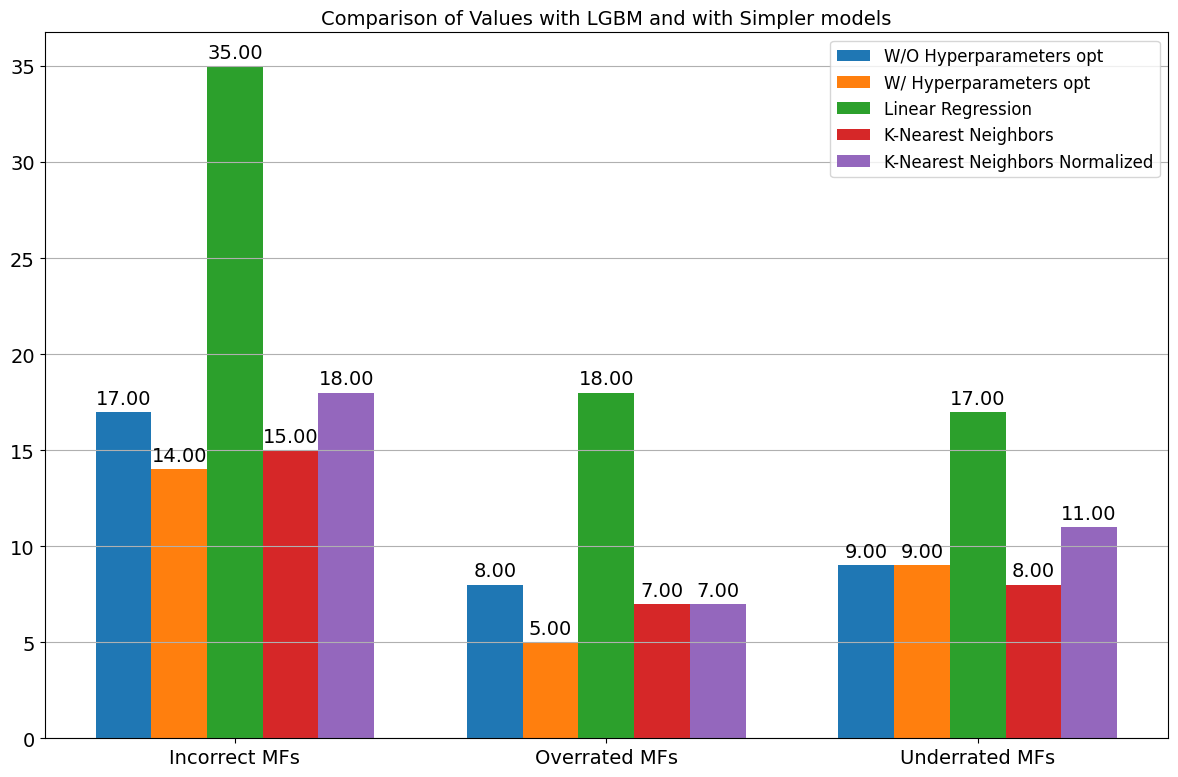

In [ ]:
# Define labels for each pair of values
labels = ['Incorrect MFs', 'Overrated MFs', 'Underrated MFs']

# Create an array with positions of the bars
x = np.arange(len(labels))  # the label locations

# Define the width of the bars
width = 0.15  # the width of the bars (adjusted for 5 bars)


fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
bars1 = ax.bar(x - 2*width, p1g, width, label='W/O Hyperparameters opt')
bars2 = ax.bar(x - width, p1g_cross, width, label='W/ Hyperparameters opt')
bars3 = ax.bar(x, p1g_lr_cross, width, label='Linear Regression')
bars4 = ax.bar(x + width, p1g_kn_cross, width, label='K-Nearest Neighbors')
bars5 = ax.bar(x + 2*width, p1g_kn_norm, width, label='K-Nearest Neighbors Normalized')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Comparison of Values with LGBM and with Simpler models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)
add_value_labels(bars5)

# Adjust layout
fig.tight_layout()
plt.grid(axis='y')
plt.savefig(res_folder+"COMPARISON_LGBM_SIMPLER_MODELS_G.png")

# Show the plot
plt.show()


As seen on the graph, the LGBM with hyperparameters is the most accurate of the models tried on this dataset. The KNN is shown to be really close to the accuracy of LGBM, but still not better overall.

### 3.6 Testing on EUROPEAN Dataset

In this paragraph we try to check if it is possible to use the model trained on the German dataset to predict the modulation formats of the European Dataset

In [ ]:
datafile = 'Dataset_european_19_node1.dat'

spans, link_occ, snr_values = read_dataset(datafile)
X_european = extract_features(spans, link_occ)
y_european = np.array(snr_values)
y_modulation_test = [SNR_to_MF(i) for i in y_european]

In [ ]:
y_snr_pred_low,y_snr_pred_high,training_duration = lgbm_regr(X_train, X_european, y_train, y_european)
y_modulation_pred = calculate_metrics(y_snr_pred_low,y_snr_pred_high, y_european, y_modulation_test, True)
peuro_cross=pred_values_lgbm_reg(y_modulation_pred,y_modulation_test)

DONE
Mean Squared Error: 1.61
Mean Absolute Error: 1.00
Accuracy: 0.57
Precision: 0.36
Recall: 0.57
F1-score: 0.43
Number of incorrectly-assigned MFs: 132
Number of overrated MFs: 130
Number of underrated MFs: 2


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


This time, using the German Dataset to train and the European Dataset to test, we got a really bad accuracy (57%) compared to the 86% of the other way (European dataset on German dataset).

This makes sense, as the german dataset is smaller than the european one.

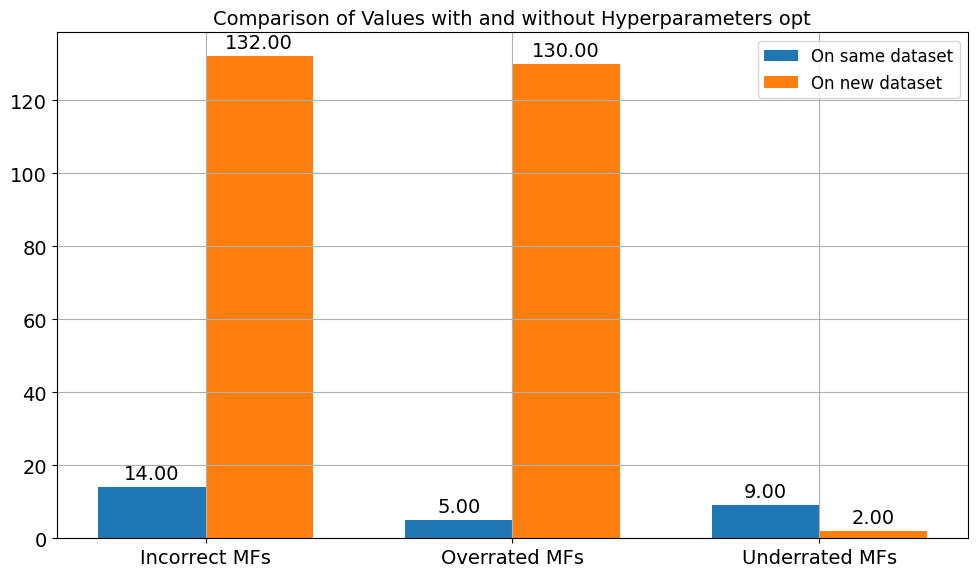

In [ ]:
# Define labels for each pair of values
labels = ['Incorrect MFs', 'Overrated MFs', 'Underrated MFs']

# Create an array with positions of the bars
x = np.arange(len(labels))  # the label locations

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
bars1 = ax.bar(x - width/2, p1g_cross, width, label='On same dataset')
bars2 = ax.bar(x + width/2, peuro_cross, width, label='On new dataset')


ax.set_title('Comparison of Values with and without Hyperparameters opt')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


add_value_labels(bars1)
add_value_labels(bars2)


fig.tight_layout()
plt.grid()
# Show the plot
plt.savefig(res_folder+f'COMPARISON_TESTING_ON_EUROPEAN.png')
plt.show()


### 3.7 Explaniable AI

We will see the relationship between the features using XAI to make sure that the model takes correct decisions based on correct reasons

In [ ]:
#set number of shap points to consider with SHAP, we can consider the whole dataset
shappoints = 1672

# Calculate SHAP values for both models
explainer_low = shap.TreeExplainer(snr_regressor_low)
explainer_high = shap.TreeExplainer(snr_regressor_high)

shap_values_low = explainer_low.shap_values(X[:shappoints])
shap_values_high = explainer_high.shap_values(X[:shappoints])

# Ensure the SHAP values have the same shape
assert shap_values_low.shape == shap_values_high.shape, "SHAP values must have the same shape."

# Average the SHAP values
mean_shap_values = np.array([np.mean([shap_values_low[i], shap_values_high[i]], axis=0) for i in range(len(shap_values_high))])
mean_shap_values

array([[-0.09367785, -1.05173974,  0.06456855, -0.04338748,  0.0578013 ,
         0.03072216],
       [-0.04738839, -0.92452215, -0.05639105, -0.39864661,  0.06065406,
         0.00527011],
       [ 0.22736351,  1.97472475,  0.12814534,  0.02209957,  0.00973668,
        -0.01213318],
       ...,
       [-0.10609655,  0.0197231 ,  0.06243369, -0.23156649, -0.03701981,
        -0.00702253],
       [-0.01863574,  0.17104295, -0.0689902 , -0.20147784, -0.06796652,
         0.01718173],
       [ 0.083799  ,  0.68327535,  0.05974632,  0.22917209, -0.00635431,
         0.03510446]])

#### Global summary plot

For this method, as we use LGBM only as a regressor, we can only plot the Global summary of the SNR values predicted, because the MFs are later mapped with the corresponding conversion, which is no longer attached with the LGBM.

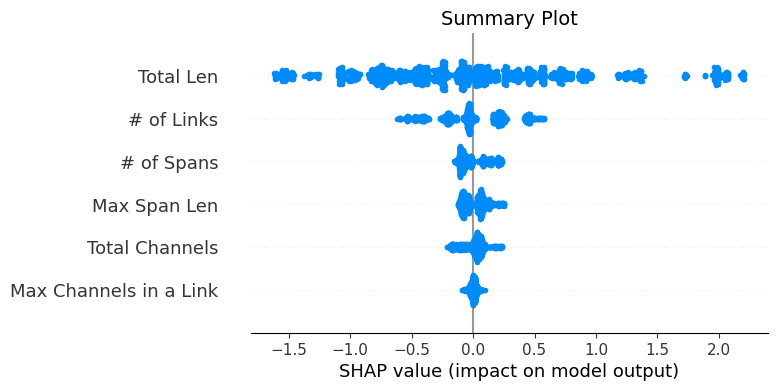

In [ ]:
lista=['# of Spans','Total Len','Max Span Len','# of Links', 'Total Channels','Max Channels in a Link']

# Plot the SHAP summary plot
shap.summary_plot(mean_shap_values, feature_names=lista, show=False, max_display=10)
plt.title("Summary Plot")
plt.savefig(res_folder+"SHAP_German_1.png")
plt.show()

For this dataset, this plot still shows that the feature "Total Len" is the one that dominates as the most important aspect for the prediction of the SNR, as expected.

Futhermore, the "# of Links" feature gets more importance for this dataset (it's also a feature corresponding to the possible interference in the lightpath).

The "# of Spans" is still a feature with a considerable influence, reasonable becaues of the influence of the increased number of Optical Amplifier that implies the higher number of spans.

## 4. Part2 LGBM as Classifier
Using directly LGBM as classifier to predict MF.

### 4.1 ML optimization and training

We do the crossvalidation technique once again, to get the best parameters for the algorithm.

In [ ]:
# Convert SNR values to modulation formats for ground truth labels
y_modulation = np.array([SNR_to_MF(snr) for snr in y])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test=split_dataset(X,y_modulation)


In [ ]:
best_params = optimize_lgbm_classifier()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'verbosity': -1, 'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 30, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best cross-validation score (F1):  0.9297878471918898
Accuracy: 0.97
Precision: 0.96
Recall: 0.97
F1-score: 0.97


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### 4.2 Without Hyperparameters optimization

First do the procedure straighforward, without the cross validation. We use the previous defined function of the last dataset.

In [ ]:
y_pred = lgbm_clas(X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 358
[LightGBM] [Info] Number of data points in the train set: 1337, number of used features: 6
[LightGBM] [Info] Start training from score -0.946280
[LightGBM] [Info] Start training from score -0.590183
[LightGBM] [Info] Start training from score -2.949688
[LightGBM] [Info] Start training from score -5.252273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Get the values for this dataset and the 2nd method.

In [ ]:
p2g=pred_values_lgbm_reg(y_pred,y_test)

Number of incorrectly-assigned MFs: 15
Number of overrated MFs: 8
Number of underrated MFs: 7


### 4.3 Using the Best Parameters found

In [ ]:
# Initialize the LightGBM classifier with best parameters
modulation_classifier = lgb.LGBMClassifier(**best_params, random_state=42)

# Train the classifier
modulation_classifier.fit(X_train, y_train)
# Predict modulation formats on the test set
y_pred = modulation_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Output results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


Accuracy: 0.97
Precision: 0.96
Recall: 0.97
F1-score: 0.97


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
p2g_cross=pred_values_lgbm_reg(y_pred,y_test)

Number of incorrectly-assigned MFs: 11
Number of overrated MFs: 6
Number of underrated MFs: 5


In [ ]:
print(p2g)
print(p2g_cross)

[15, 8, 7]
[11, 6, 5]


As expected, using the hyperparameters allows us to get a more accurate algorithm (from 0.96 to 0.97) which turns in result 4 less incorrectly assigned MFs. See below a graph of this relationship.

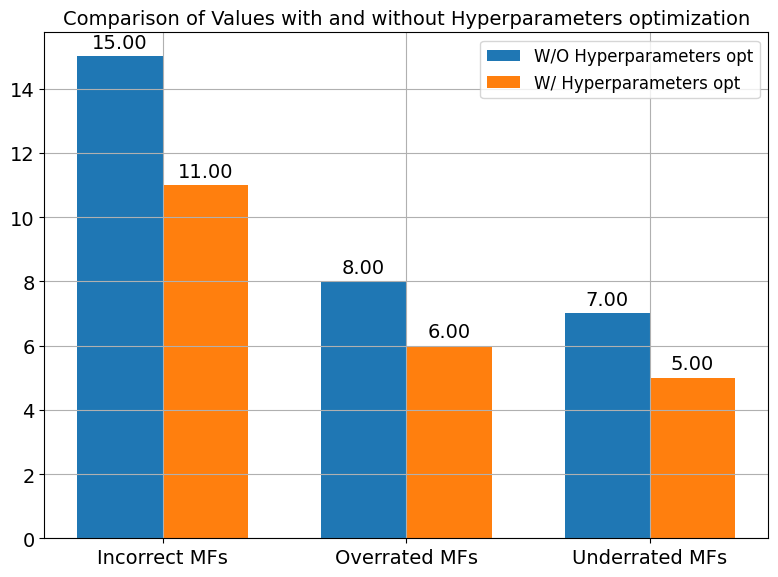

In [ ]:
# Define labels for each pair of values
labels = ['Incorrect MFs', 'Overrated MFs', 'Underrated MFs']

# Create an array with positions of the bars
x = np.arange(len(labels))  # the label locations

# Define the width of the bars
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (8,6))

# Plot the data
bars1 = ax.bar(x - width/2, p2g, width, label='W/O Hyperparameters opt')
bars2 = ax.bar(x + width/2, p2g_cross, width, label='W/ Hyperparameters opt')

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_title('Comparison of Values with and without Hyperparameters optimization')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
add_value_labels(bars1)
add_value_labels(bars2)

# Adjust layout
fig.tight_layout()
plt.grid()
plt.savefig(res_folder+"COMPARISON_GERMAN_2.png")
# Show the plot
plt.show()

### 4.4 Simpler models

In this method we don't need to take into account quantiles, so we use the LogisticRegression and KNeighborsClassifier from the scikit-learn library

#### 4.4.1 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the Logistic Regression classifier
logistic_classifier = LogisticRegression(random_state=42, max_iter=1000)

# Train the classifier
logistic_classifier.fit(X_train, y_train)

# Predict modulation formats on the test set
y_pred_logistic = logistic_classifier.predict(X_test)

# Evaluate the classifier
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic, average='weighted')
recall_logistic = recall_score(y_test, y_pred_logistic, average='weighted')
f1_logistic = f1_score(y_test, y_pred_logistic, average='weighted')

# Output results
print('Logistic Regression:')
print(f'Accuracy: {accuracy_logistic:.2f}')
print(f'Precision: {precision_logistic:.2f}')
print(f'Recall: {recall_logistic:.2f}')
print(f'F1-score: {f1_logistic:.2f}')


Logistic Regression:
Accuracy: 0.96
Precision: 0.95
Recall: 0.96
F1-score: 0.95


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
p2g_logr_cross=pred_values_lgbm_reg(y_pred_logistic,y_test)

Number of incorrectly-assigned MFs: 15
Number of overrated MFs: 7
Number of underrated MFs: 8


The Logistic Regression gets a high accuracy, but a little less than the LGBM with Hyperparameters.

#### 4.4.2 K_Nearest Neighbors

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier

# Initialize the K-Nearest Neighbors classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Predict modulation formats on the test set
y_pred_knn = knn_classifier.predict(X_test)

# Evaluate the classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

# Output results
print('K-Nearest Neighbors:')
print(f'Accuracy: {accuracy_knn:.2f}')
print(f'Precision: {precision_knn:.2f}')
print(f'Recall: {recall_knn:.2f}')
print(f'F1-score: {f1_knn:.2f}')


K-Nearest Neighbors:
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-score: 0.94


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
p2g_knn_cross=pred_values_lgbm_reg(y_pred_knn,y_test)

Number of incorrectly-assigned MFs: 19
Number of overrated MFs: 9
Number of underrated MFs: 10


The KNN classifier didn't improve the accuracy compared to the logistic one. Let's see with the normalized KNN.

#### 4.4.3 KNN+NORMALIZATION

In [ ]:
#Normalize X
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

display (X_train_scaled)
#display (y_train_scaled)
display (X_test_scaled)
#display (y_test_scaled)

# Initialize the K-Nearest Neighbors classifier
knn_classifier_norm = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_classifier_norm.fit(X_train_scaled, y_train)

# Predict modulation formats on the test set
y_pred_knn_norm = knn_classifier_norm.predict(X_test_scaled)

# Evaluate the classifier
accuracy_knn_norm = accuracy_score(y_test, y_pred_knn_norm)
precision_knn_norm = precision_score(y_test, y_pred_knn_norm, average='weighted')
recall_knn_norm = recall_score(y_test, y_pred_knn_norm, average='weighted')
f1_knn_norm = f1_score(y_test, y_pred_knn_norm, average='weighted')

# Output results
print('K-Nearest Neighbors:')
print(f'Accuracy: {accuracy_knn_norm:.2f}')
print(f'Precision: {precision_knn_norm:.2f}')
print(f'Recall: {recall_knn_norm:.2f}')
print(f'F1-score: {f1_knn_norm:.2f}')

array([[0.07142857, 0.04043716, 0.02272727, 0.16666667, 0.05769231,
        0.21276596],
       [0.28571429, 0.30491803, 0.77272727, 0.16666667, 0.0625    ,
        0.19148936],
       [0.71428571, 0.69617486, 1.        , 0.5       , 0.31730769,
        0.76595745],
       ...,
       [0.35714286, 0.36065574, 0.77272727, 0.16666667, 0.11538462,
        0.31914894],
       [0.64285714, 0.64699454, 0.77272727, 0.33333333, 0.13942308,
        0.27659574],
       [0.35714286, 0.35956284, 0.77272727, 0.33333333, 0.14903846,
        0.40425532]])

array([[0.78571429, 0.77486339, 1.        , 0.83333333, 0.80769231,
        0.9787234 ],
       [0.28571429, 0.25901639, 0.77272727, 0.16666667, 0.01923077,
        0.06382979],
       [0.07142857, 0.04043716, 0.02272727, 0.16666667, 0.04326923,
        0.12765957],
       ...,
       [0.64285714, 0.64480874, 1.        , 0.5       , 0.32692308,
        0.82978723],
       [0.35714286, 0.3989071 , 1.        , 0.16666667, 0.21153846,
        0.70212766],
       [0.57142857, 0.50928962, 0.63636364, 0.33333333, 0.44230769,
        1.        ]])

K-Nearest Neighbors:
Accuracy: 0.95
Precision: 0.94
Recall: 0.95
F1-score: 0.94


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
p2g_knn_norm=pred_values_lgbm_reg(y_pred_knn_norm,y_test)

Number of incorrectly-assigned MFs: 18
Number of overrated MFs: 7
Number of underrated MFs: 11


The KNN Normalized improved the accuracy, but still less than the logistic one, proving that the LGBM is the correct choice as the classifier for this case.

### 4.5 Comparison Simpler Models vs LGBM

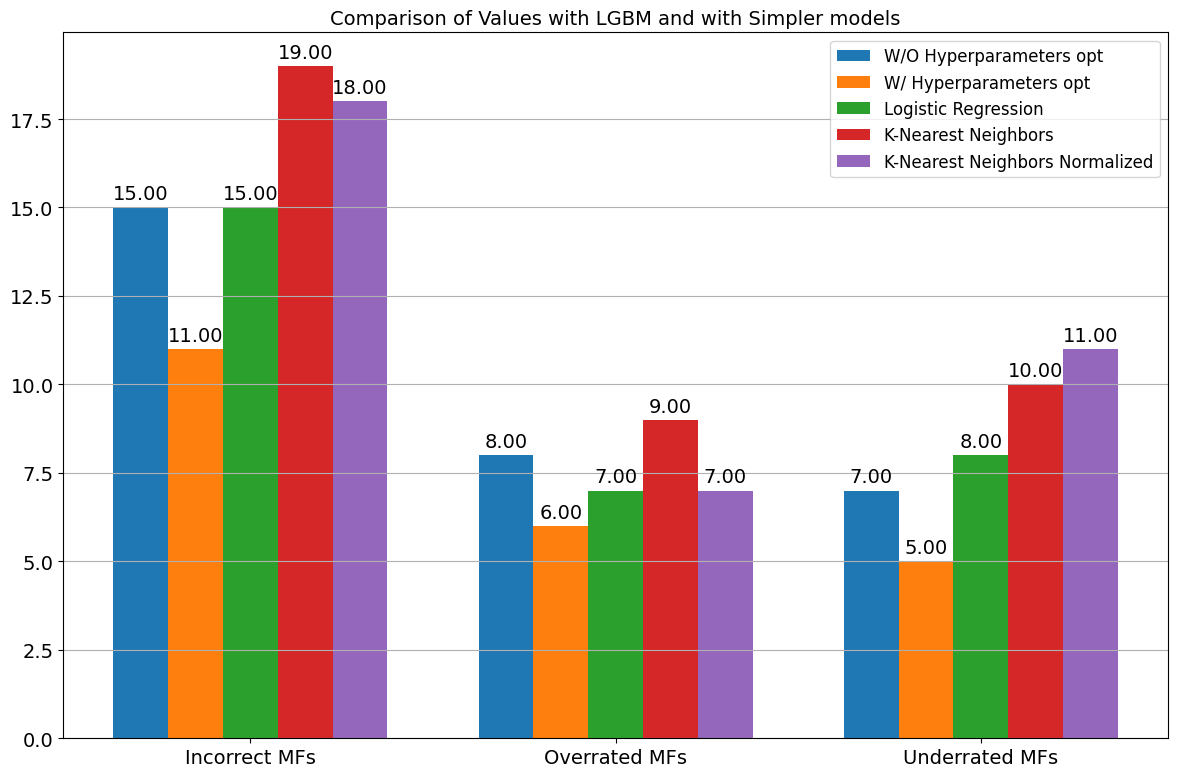

In [ ]:


# Define labels for each pair of values
labels = ['Incorrect MFs', 'Overrated MFs', 'Underrated MFs']

# Create an array with positions of the bars
x = np.arange(len(labels))  # the label locations

# Define the width of the bars
width = 0.15  # the width of the bars (adjusted for 5 bars)


fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
bars1 = ax.bar(x - 2*width, p2g, width, label='W/O Hyperparameters opt')
bars2 = ax.bar(x - width, p2g_cross, width, label='W/ Hyperparameters opt')
bars3 = ax.bar(x, p2g_logr_cross, width, label='Logistic Regression')
bars4 = ax.bar(x + width, p2g_knn_cross, width, label='K-Nearest Neighbors')
bars5 = ax.bar(x + 2*width, p2g_knn_norm, width, label='K-Nearest Neighbors Normalized')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Comparison of Values with LGBM and with Simpler models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)
add_value_labels(bars5)

# Adjust layout
fig.tight_layout()
plt.grid(axis='y')
plt.savefig(res_folder+"COMPARISON_LGBM_SIMPLER_MODELS_G2.png")

# Show the plot
plt.show()




With this graph we can conclude that, indeed, the LGBM with hyperparameters is an excellent choice as a classifier for our model.

### 4.6 Explaniable AI

We will see the relationship between the features using XAI to make sure that the model takes correct decisions based on correct reasons

In [ ]:
#set number of shap points to consider with SHAP, we can consider the whole dataset
shappoints = 1672

#create and initialize explainer, we use TreeExplainer and pass the modulation classifier as an argument
explainer_shap = shap.TreeExplainer(modulation_classifier)

#Calculating the SHAP values by using shap_values method. It takes training data as an argument
shap_values = explainer_shap.shap_values(X[:shappoints])

#shap_values

# Get the class labels from the classifier
class_labels = modulation_classifier.classes_

# Print the class labels and corresponding SHAP values arrays
for label, shap_value in zip(class_labels, shap_values):
    print(f"Class label: {label}")
    print(shap_value)

Class label: 8
[[ 0.84449776  2.67439847 -0.07229083 -0.3269668   0.0484384   0.10316768]
 [ 0.86573972  2.21199609  0.09588958  0.70236953  0.11328489 -0.00889154]
 [-0.64170172 -1.60559859 -0.21216456 -0.31739473 -0.08683704  0.00330417]
 ...
 [ 0.38126832 -0.74477641 -0.41297729  0.49233837  0.26389877  0.13410267]
 [-0.44392786 -0.99638411  0.18184444  0.46460504  0.1596215  -0.14048937]
 [-0.72157472 -1.67792395 -0.14637354 -0.30737277  0.06224323 -0.03666203]]
Class label: 16
[[-0.51279368 -2.04280136  0.17029997  0.3739006   0.03882916 -0.18991381]
 [-0.54814645 -1.7850201  -0.19229297 -0.92424297 -0.16386338  0.04182895]
 [ 0.14241305 -0.40560261  0.41006031  0.73708016  0.17454257  0.02686125]
 ...
 [ 0.02666179  1.04157185  0.40102575 -0.65770117 -0.19654787 -0.05113027]
 [ 0.57410042  1.57882356 -0.32523211 -0.53451901 -0.16440199  0.05930593]
 [ 0.46288728  1.59133919  0.36938455  0.5942783  -0.08217973  0.04518447]]
Class label: 32
[[-0.04198644 -0.2363463  -0.01928381 -0.

#### Global summary plot

We show first the plot of all the predicted MFs, and the overall relationship of the prediction with the features of the lightpath. Now, as we use lgbm as a classifier, we can show the various types of MFs and not only raw SNR values.

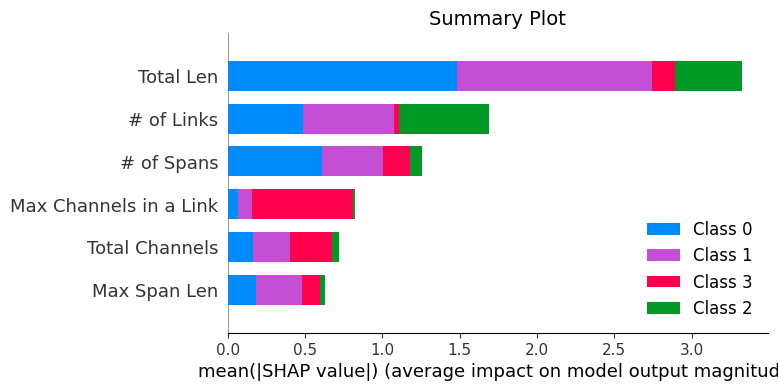

In [ ]:
lista=['# of Spans','Total Len','Max Span Len','# of Links', 'Total Channels','Max Channels in a Link']

shap.summary_plot(shap_values, feature_names=lista, show = False, max_display=10)
plt.title("Summary Plot")
plt.savefig(res_folder+"SHAP_German_2.png")
plt.show()

As it can be seen on the summary plot shown above, the "Total Len" is as expected the feature with the most impact on the model (by quite a lot). Obviously, as longer the lightpath, the less the SNR will be.

The second and third most impactful are the "# of Links" (more chance of interference) and "# of Spans" (More amplifiers used, so more AES error), which was also concluded from the graphs of the features on the Data preprocessing section of the notebook.

The lest influential feature is the one of "Max Span Len", as in can occur that there is a lenghty span but the lightpath has only 1 span, this wouldn't be of high impact.

#### Summary plot for each class of modulation found

For this method we posses different MFs (classes) predicted, which allows us to create summary plots of the influence of the lightpath features on each of the MF selected.

In [ ]:
# Find the number of distinct labels and make a list of distinct labels for later use
n_label = len(set(y_modulation))
labels = list(set(y_modulation))

print(n_label)
print(labels)

4
[8, 16, 32, 64]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


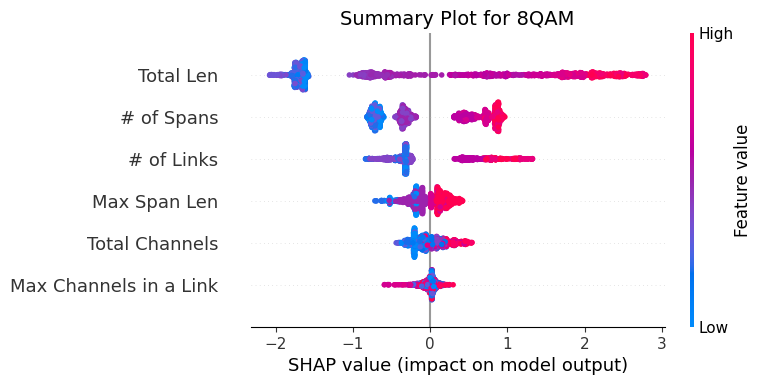

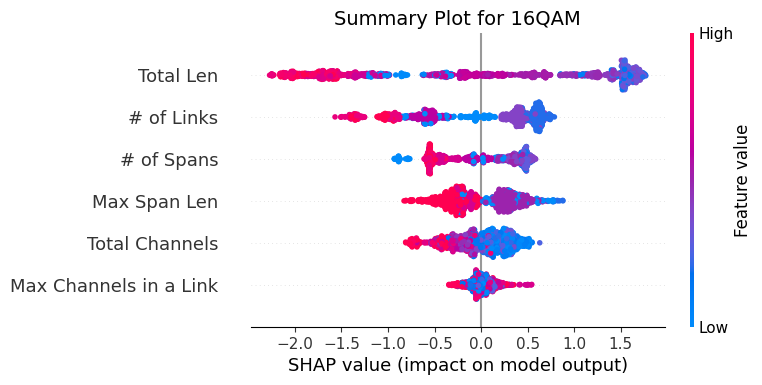

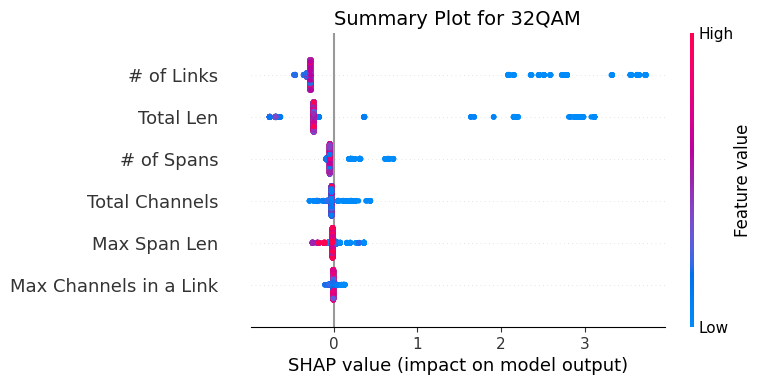

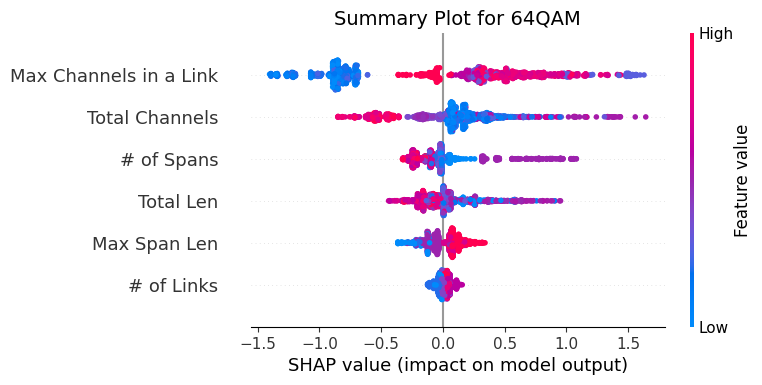

In [ ]:
#4 (QPSK), 8 (8QAM), 16 (16QAM), 32 (32QAM), 64 (64QAM)

class_name = ['8QAM', '16QAM', '32QAM', '64QAM']

#Iterate over labels (classes) and plot SHAP's summary plot of each label using shap.summary_plot method
#method takes shap_values of the class, data set (from this SHAP gets features' values) and features names
#in addition to the number of features to display
#we use show = False so the figure is not directly plotted so we can add a unique title to it in a next step
for class_ind in range(n_label):
    shap.summary_plot(shap_values[class_ind], features=X[:shappoints], feature_names=lista,
                      show = False, max_display=10)

    title = 'Summary Plot for ' + str(class_name[class_ind])
    plt.title(title)
    plt.savefig(res_folder+f"{class_name[class_ind]}_GERMAN.png")
    plt.show()

On the first two types of MFs (8QAM and 16QAM) we found that the the "Total Len" is indeed the most important feature to determine if they are the one used.

For 32QAM, "# of Links" as well as "Total Len" are by far the two most important deciding features for this type of MF.

However, for 64QAM the feature of "Max Channels in a Link" takes the place as the most impactful feature. So, the interference provoqued by the links represent the deciding factor of choosing this MF. On the other MFs, this feature was the less important.

## 5. Comparison of both methods

Now we compare the two methods using a graph similar to the previous ones.

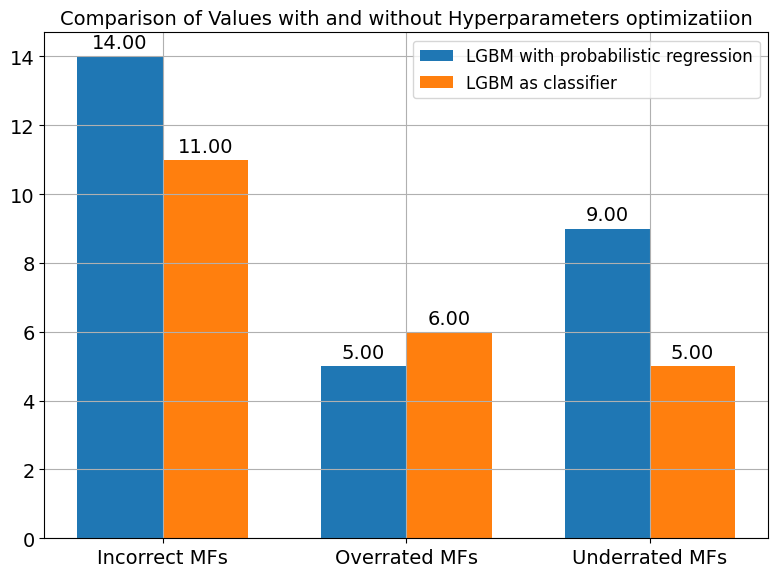

In [ ]:
# Define labels for each pair of values
labels = ['Incorrect MFs', 'Overrated MFs', 'Underrated MFs']

# Create an array with positions of the bars
x = np.arange(len(labels))  # the label locations

# Define the width of the bars
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (8,6))

# Plot the data
bars1 = ax.bar(x - width/2, p1g_cross, width, label='LGBM with probabilistic regression')
bars2 = ax.bar(x + width/2, p2g_cross, width, label='LGBM as classifier')

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_title('Comparison of Values with and without Hyperparameters optimizatiion')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
add_value_labels(bars1)
add_value_labels(bars2)

# Adjust layout
fig.tight_layout()
plt.grid()
plt.savefig(res_folder+"Comparison_probabilistic_regression_classifier_GERMAN.png")

# Show the plot
plt.show()

For this dataset we got a different result from the previous one, as the LGBM with probabilistic regression turned into having 3 more incorrectly-assigned MFs compared to the LGBM as the classifier. Still, both methods of proceding had a really high accuracy (0.96 and 0.97).

One additional conclussion is that for this dataset the accuracy was higher than the one obtained on the first dataset. This could be atttributed to being that we got features of nodes inside a country compared to features of a continent, which give a finer granularity and can allow for a best approximation.